In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

import warnings

# EDA

In [3]:
df = pd.read_csv("C:\\Users\\alaba\\OneDrive\\Desktop\\Nexum-ArabCab-Competition\\data\\ArabCab Nexum Dataset.csv", index_col="date")

In [4]:
df.head()

,material_name,actual_consumption_tons,month,quarter,is_peak_construction_season,confirmed_contract_volume_tons,project_based_demand_flag,number_of_active_projects,raw_material_price_index,energy_cost_index,demand_growth_trend_index,demand_volatility_index
date,,,,,,,,,,,,
1/1/2019,LSF,27,1,1,0,0,0,1,97.0,98.0,96.0,0.09
2/1/2019,LSF,27,2,1,0,0,0,1,97.5,98.5,96.5,0.08
3/1/2019,LSF,28,3,1,0,0,0,2,98.0,98.8,97.5,0.09
4/1/2019,LSF,32,4,2,1,2,0,2,98.5,99.2,102.8,0.11
5/1/2019,LSF,34,5,2,1,2,0,2,99.0,99.8,105.5,0.12


In [5]:
df_LSF = df[df["material_name"] == "LSF"]
df_XLPE = df[df["material_name"] == "XLPE"]
df_PE = df[df["material_name"] == "PE"]
df_PVC = df[df["material_name"] == "PVC"]

In [6]:
dataset_LSF = df_LSF[["actual_consumption_tons"]]
dataset_XLPE = df_XLPE[["actual_consumption_tons"]]
dataset_PE = df_PE[["actual_consumption_tons"]]
dataset_PVC = df_PVC[["actual_consumption_tons"]]

<Axes: xlabel='date'>

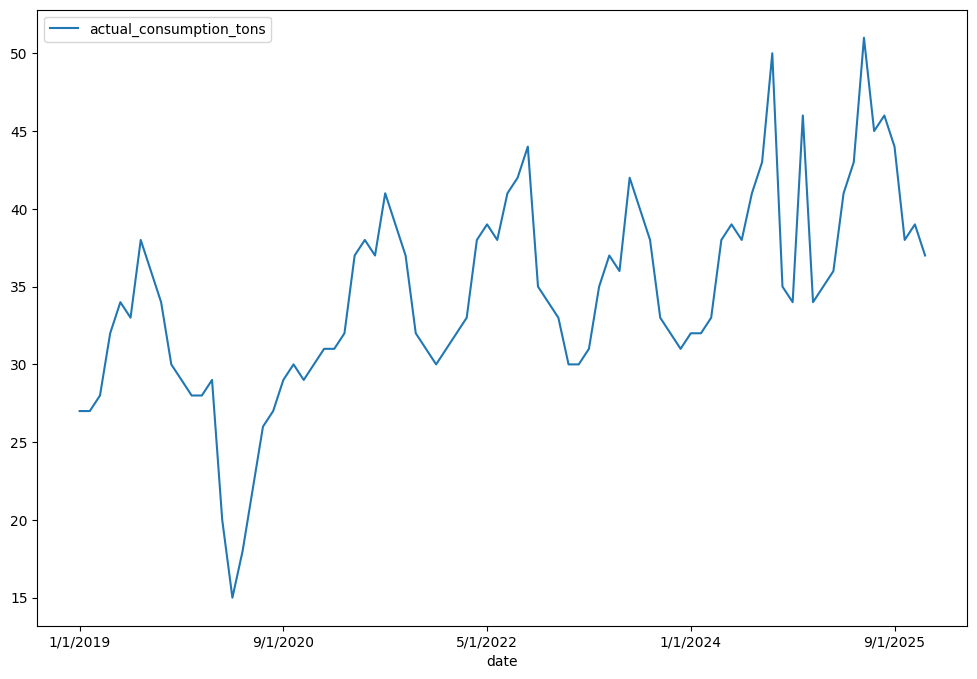

In [7]:
dataset_LSF.plot(figsize=(12,8))

<Axes: xlabel='date'>

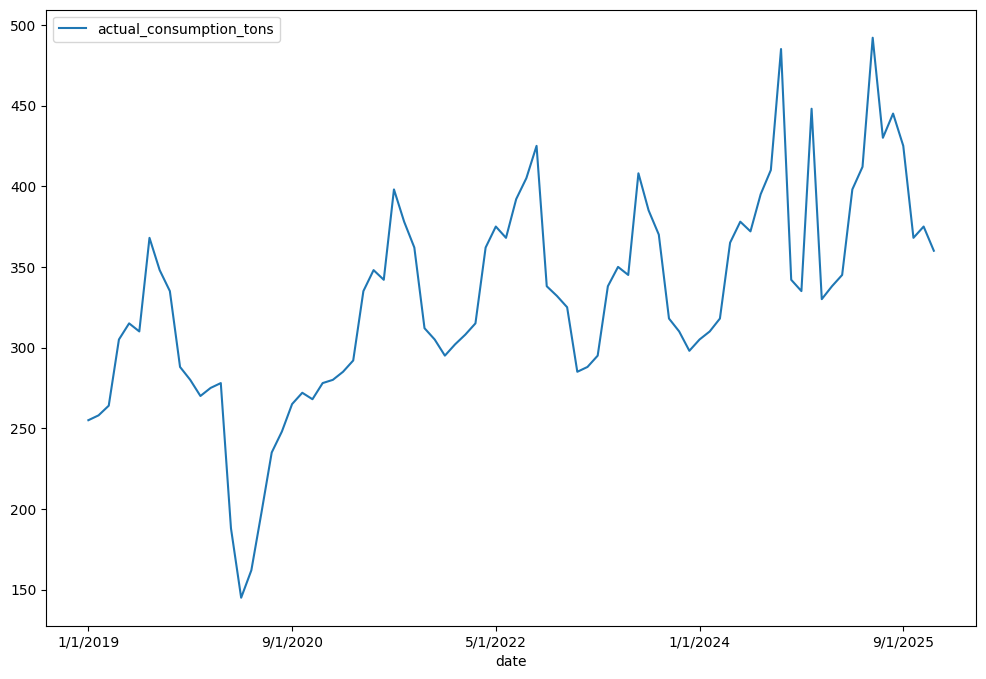

In [8]:
dataset_XLPE.plot(figsize=(12,8))

<Axes: xlabel='date'>

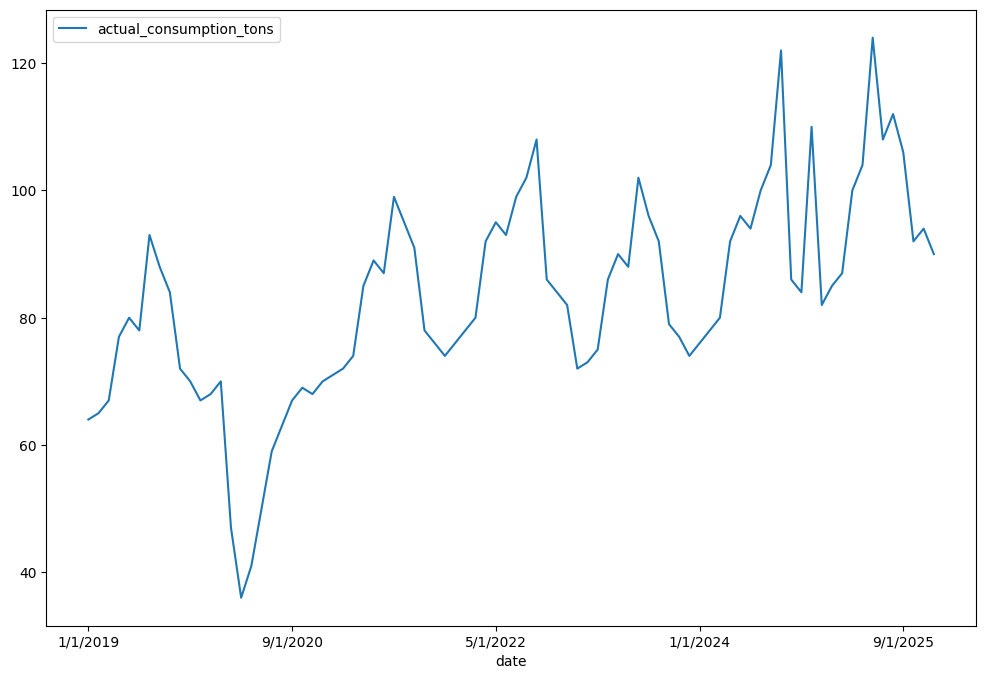

In [9]:
dataset_PE.plot(figsize=(12,8))

<Axes: xlabel='date'>

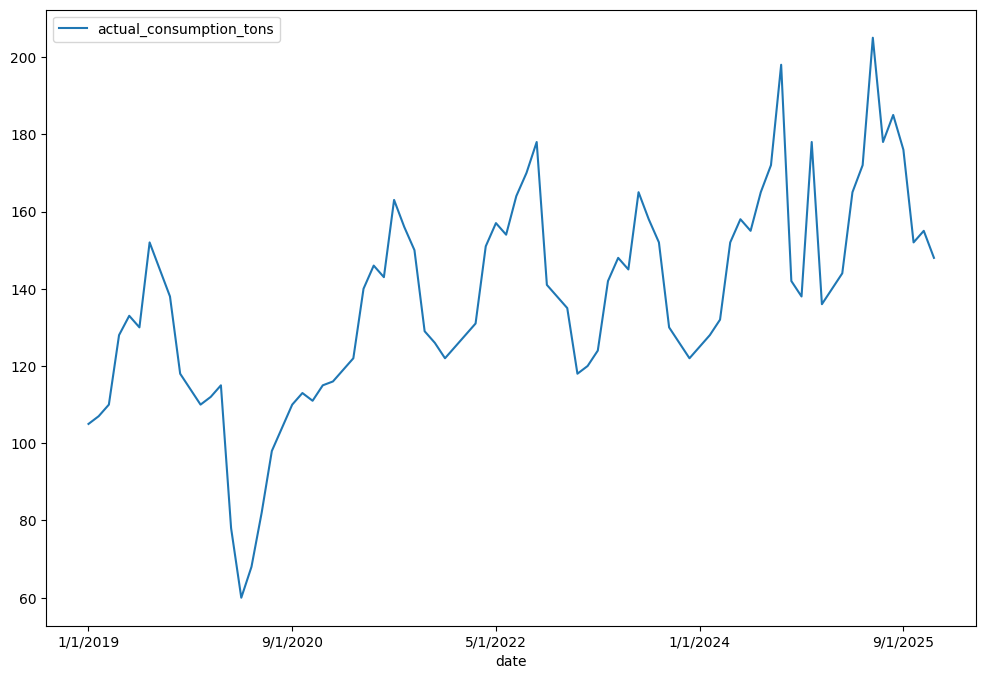

In [10]:
dataset_PVC.plot(figsize=(12,8))

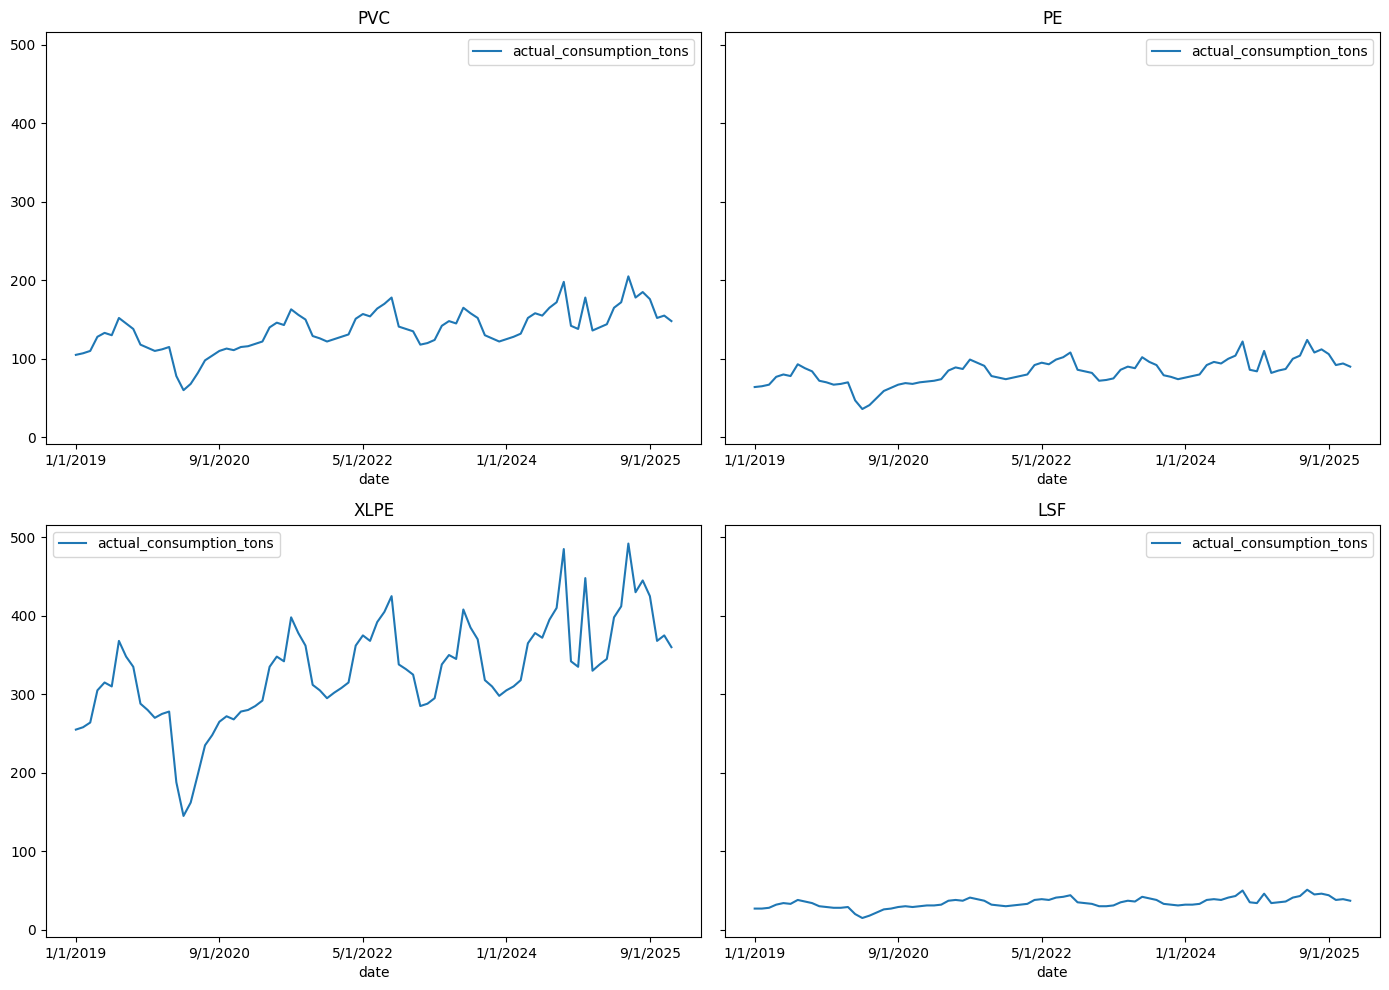

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

dataset_PVC.plot(ax=axes[0,0], title="PVC")
dataset_PE.plot(ax=axes[0,1], title="PE")
dataset_XLPE.plot(ax=axes[1,0], title="XLPE")
dataset_LSF.plot(ax=axes[1,1], title="LSF")

plt.tight_layout()
plt.show()

## EDA

In [12]:
df_LSF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84 entries, 1/1/2019 to 12/1/2025
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   material_name                   84 non-null     object 
 1   actual_consumption_tons         84 non-null     int64  
 2   month                           84 non-null     int64  
 3   quarter                         84 non-null     int64  
 4   is_peak_construction_season     84 non-null     int64  
 5   confirmed_contract_volume_tons  84 non-null     int64  
 6   project_based_demand_flag       84 non-null     int64  
 7   number_of_active_projects       84 non-null     int64  
 8   raw_material_price_index        84 non-null     float64
 9   energy_cost_index               84 non-null     float64
 10  demand_growth_trend_index       84 non-null     float64
 11  demand_volatility_index         84 non-null     float64
dtypes: float64(4), int64(7), obje

In [13]:
df_LSF = df_LSF.drop(columns=["material_name", "quarter", "month"])

In [14]:
train_size = int(0.8 * len(df_LSF))

test_size = len(df_LSF) - train_size

print(f"Train size: {train_size}")
print(f"Test size: {test_size}")

Train size: 67
Test size: 17


In [15]:
data = df_LSF.values
train = data[:train_size, :]

test = data[train_size-12:, :]

In [16]:
feature_cols = [c for c in df_LSF.columns if c != "actual_consumption_tons"]

train_size = int(0.8 * len(df_LSF))
train_df = df_LSF.iloc[:train_size]
test_df  = df_LSF.iloc[train_size:]

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = x_scaler.fit_transform(train_df[feature_cols])
X_test_scaled  = x_scaler.transform(test_df[feature_cols])

y_train_scaled = y_scaler.fit_transform(train_df[["actual_consumption_tons"]]).ravel()
y_test_scaled  = y_scaler.transform(test_df[["actual_consumption_tons"]]).ravel()


# Models

## RandomForest Regression

In [17]:
rf_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5]
}

rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_params,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1
)

rf_grid.fit(X_train_scaled, y_train_scaled)

print("RF Best Params:", rf_grid.best_params_)
print("RF Best CV MAE:", -rf_grid.best_score_)

rf_best = rf_grid.best_estimator_

RF Best Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
RF Best CV MAE: 0.11197969197219566


In [18]:
model = RandomForestRegressor(max_depth=10, min_samples_split=2, n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train_scaled)

pred = model.predict(X_test_scaled)
print("MAE =", mean_absolute_error(y_test_scaled, pred))


MAE = 0.13488032454361065


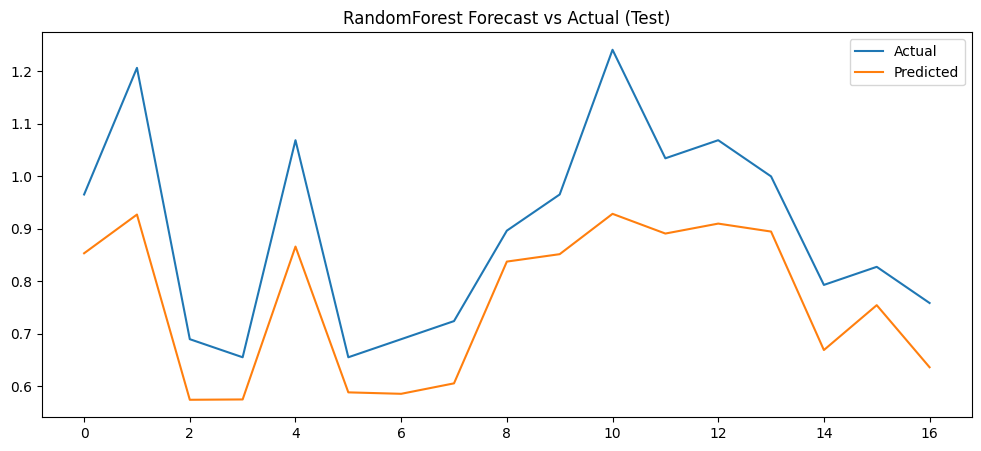

In [19]:
plt.figure(figsize=(12,5))
plt.plot(y_test_scaled, label="Actual")
plt.plot(pred, label="Predicted")
plt.legend()
plt.title("RandomForest Forecast vs Actual (Test)")
plt.show()


## Gradient Boosting Model

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

gb_params = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2, 3, 4]
}

gb_grid = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=gb_params,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1
)

gb_grid.fit(X_train_scaled, y_train_scaled)

print("GB Best Params:", gb_grid.best_params_)
print("GB Best CV MAE:", -gb_grid.best_score_)

gb_best = gb_grid.best_estimator_


GB Best Params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300}
GB Best CV MAE: 0.10205391507968598


In [21]:
from sklearn.metrics import mean_absolute_error

gb_pred = gb_best.predict(X_test_scaled)

gb_mae = mean_absolute_error(y_test_scaled, gb_pred)

print("GB Test MAE:", gb_mae)

GB Test MAE: 0.1327151031258556


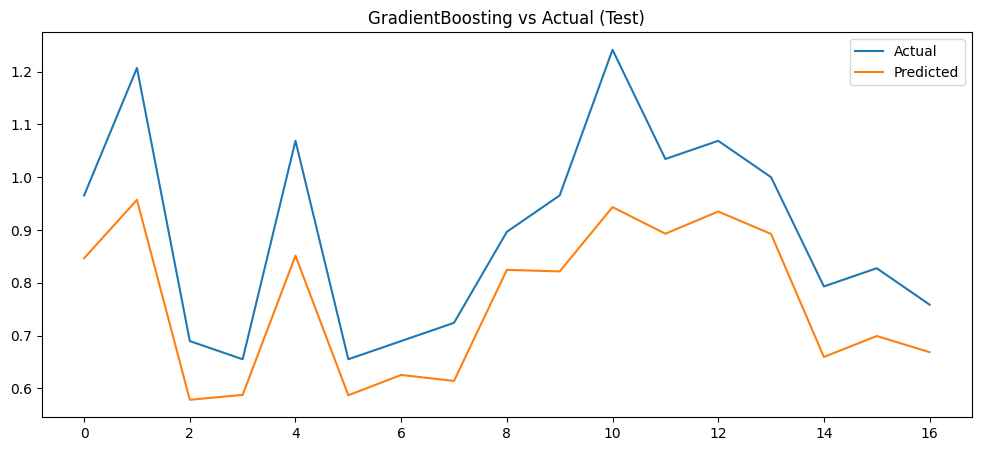

In [22]:
plt.figure(figsize=(12,5))
plt.plot(y_test_scaled, label="Actual")
plt.plot(gb_pred, label="Predicted")
plt.legend()
plt.title("GradientBoosting vs Actual (Test)")
plt.show()


## LightGBM Model

In [23]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

lgbm_params = {
    "n_estimators": [200, 300],
    "learning_rate": [0.03, 0.05],
    "max_depth": [-1, 5, 10]
}

lgbm_grid = GridSearchCV(
    LGBMRegressor(random_state=42, verbose=-1),
    lgbm_params,
    scoring="neg_mean_absolute_error",
    cv=3
)

lgbm_grid.fit(X_train_scaled, y_train_scaled)

lgbm_best = lgbm_grid.best_estimator_

lgbm_pred = lgbm_best.predict(X_test_scaled)
lgbm_mae = mean_absolute_error(y_test_scaled, lgbm_pred)

print("LightGBM Best Params:", lgbm_grid.best_params_)
print("LightGBM MAE:", lgbm_mae)

c:\Users\alaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\d

LightGBM Best Params: {'learning_rate': 0.03, 'max_depth': -1, 'n_estimators': 300}
LightGBM MAE: 0.16337341638056477


c:\Users\alaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\d

In [24]:
from sklearn.metrics import mean_absolute_error
lgbm = LGBMRegressor(
    n_estimators=300,
    max_depth = -1,
    verbose = -1,
    learning_rate=0.03,
    random_state=42
)

lgbm.fit(X_train_scaled, y_train_scaled)

lgbm_pred = lgbm.predict(X_test_scaled)

lgbm_mae = mean_absolute_error(y_test_scaled, lgbm_pred)

print("LightGBM MAE:", lgbm_mae)

LightGBM MAE: 0.16337341638056477


c:\Users\alaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


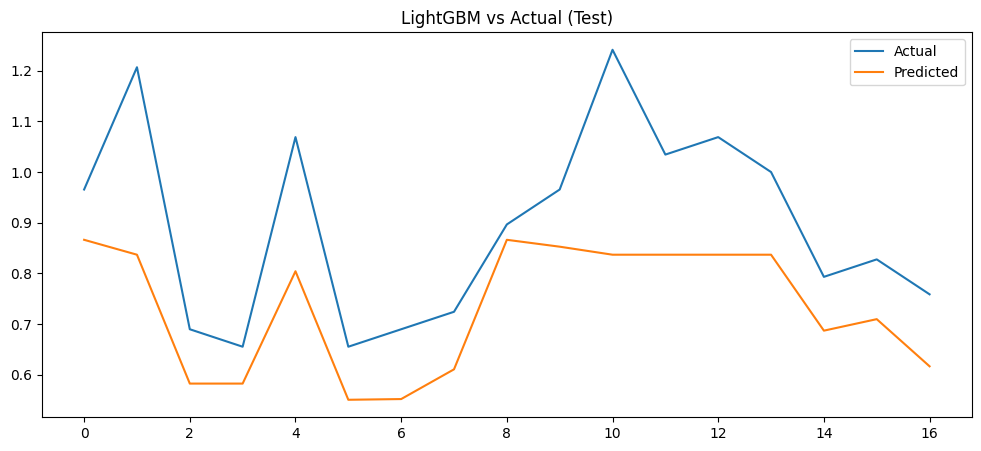

In [25]:
plt.figure(figsize=(12,5))
plt.plot(y_test_scaled, label="Actual")
plt.plot(lgbm_pred, label="Predicted")
plt.legend()
plt.title("LightGBM vs Actual (Test)")
plt.show()


## Catboost Model

In [26]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

cat_params = {
    "depth": [4, 6, 8],
    "learning_rate": [0.03, 0.05],
    "iterations": [200, 300]
}

cat_grid = GridSearchCV(
    CatBoostRegressor(random_state=42, verbose=0),
    cat_params,
    scoring="neg_mean_absolute_error",
    cv=3
)

cat_grid.fit(X_train_scaled, y_train_scaled)

cat_best = cat_grid.best_estimator_

cat_pred = cat_best.predict(X_test_scaled)
cat_mae = mean_absolute_error(y_test_scaled, cat_pred)

print("CatBoost Best Params:", cat_grid.best_params_)
print("CatBoost MAE:", cat_mae)

CatBoost Best Params: {'depth': 4, 'iterations': 300, 'learning_rate': 0.05}
CatBoost MAE: 0.16059409121510607


In [27]:
from sklearn.metrics import mean_absolute_error

cat = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    random_state=42,
    verbose=0   
)

cat.fit(X_train_scaled, y_train_scaled)

cat_pred = cat.predict(X_test_scaled)
cat_mae = mean_absolute_error(y_test_scaled, cat_pred)

print("CatBoost MAE:", cat_mae)

CatBoost MAE: 0.16999287661853135


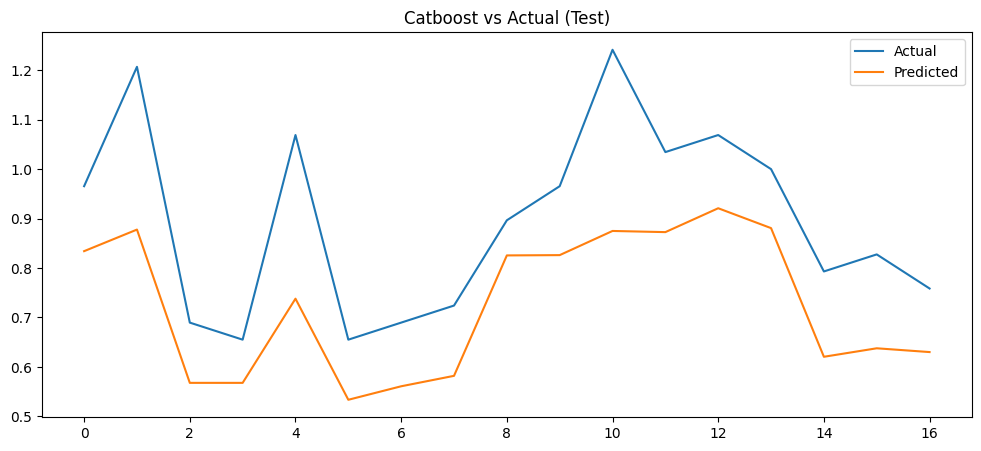

In [28]:
plt.figure(figsize=(12,5))
plt.plot(y_test_scaled, label="Actual")
plt.plot(cat_pred, label="Predicted")
plt.legend()
plt.title("Catboost vs Actual (Test)")
plt.show()


## XGBoost Model

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

xgb_params = {
    "n_estimators": [300, 500],
    "learning_rate": [0.03, 0.05],
    "max_depth": [3, 5, 7]
}

xgb_grid = GridSearchCV(
    XGBRegressor(
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    xgb_params,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1
)

xgb_grid.fit(X_train_scaled, y_train_scaled)

xgb_best = xgb_grid.best_estimator_

xgb_pred = xgb_best.predict(X_test_scaled)
xgb_mae = mean_absolute_error(y_test_scaled, xgb_pred)

print("XGBoost Best Params:", xgb_grid.best_params_)
print("XGBoost MAE:", xgb_mae)

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test_scaled, label="Actual")
plt.plot(xgb_pred, label="Predicted")
plt.legend()
plt.title("XGBoost vs Actual (Test)")
plt.show()


## LSTM Model

In [29]:
X_train = []
y_train = []

for i in range(12,len(X_train_scaled)):
    X_train.append(X_train_scaled[i-12:i, :])
    y_train.append(y_train_scaled[i])  

X_train = np.array(X_train)
y_train = np.array(y_train)

In [30]:
X_test_full = np.vstack([X_train_scaled[-12:], X_test_scaled])
y_test_full = np.concatenate([y_train_scaled[-12:], y_test_scaled])

X_test, y_test = [], []

for i in range(12, len(X_test_full)):
    X_test.append(X_test_full[i-12:i, :])
    y_test.append(y_test_full[i])

X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_test.shape, y_test.shape)

(17, 12, 8) (17,)


In [31]:
X_train.shape

(55, 12, 8)

In [32]:
y_train.shape

(55,)

In [33]:
X_test.shape

(17, 12, 8)

In [34]:
y_test.shape

(17,)

In [35]:
model = Sequential([
    LSTM(16, input_shape=X_train.shape[1:]),
    Dropout(0.3),
    Dense(1)
])

from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-3), loss=Huber(), metrics=['mae'])


c:\Users\alaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-5)
]


In [37]:
model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=8,
    callbacks=callbacks, verbose=1, shuffle=False
)


Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.1274 - mae: 0.4605 - val_loss: 0.1145 - val_mae: 0.4602 - learning_rate: 0.0010
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0528 - mae: 0.2787 - val_loss: 0.0500 - val_mae: 0.2895 - learning_rate: 0.0010
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0348 - mae: 0.2179 - val_loss: 0.0184 - val_mae: 0.1482 - learning_rate: 0.0010
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0214 - mae: 0.1609 - val_loss: 0.0094 - val_mae: 0.1139 - learning_rate: 0.0010
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0381 - mae: 0.2249 - val_loss: 0.0089 - val_mae: 0.1141 - learning_rate: 0.0010
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0362 - mae: 0.2268 - val_loss: 0.0124 - val_mae: 0.1168 - learning_rate: 0.0010
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0263 - mae: 0.1839 - val_loss: 0.0180 - val_mae: 0.1474 - learning_rate: 0.0010
Epoch 8/200
6/6 ━━━━

In [38]:
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

y_true = y_scaler.inverse_transform(y_test.reshape(-1, 1))

mae_tons = mean_absolute_error(y_true, y_pred)
rmse_tons = np.sqrt(mean_squared_error(y_true, y_pred))

print("MAE (tons):", mae_tons)
print("RMSE (tons):", rmse_tons)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
MAE (tons): 5.136446784524356
RMSE (tons): 6.6900526755103


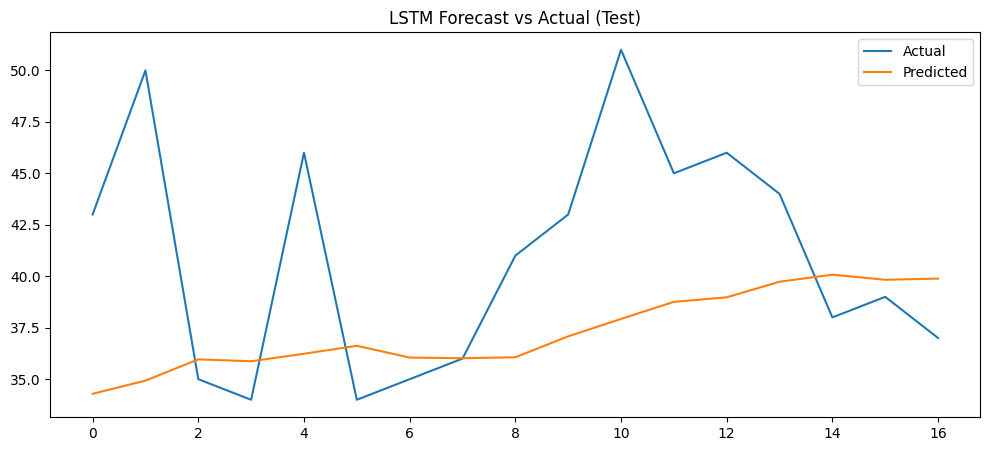

In [39]:
plt.figure(figsize=(12,5))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("LSTM Forecast vs Actual (Test)")
plt.show()


## ARIMA 

In [40]:
warnings.filterwarnings("ignore")

def arima_grid_search(df):
    p_values=range(0, 6)
    d_values=range(0, 3)
    q_values=range(0, 6)
    split_idx = int(len(df) * (1 - 0.2))
    X_train, y_test = df.iloc[:split_idx], df.iloc[split_idx:]

    results = []

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)

                if p == 0 and d == 0 and q == 0:
                    continue

                try:
                    model = ARIMA(X_train, order=order)
                    result = model.fit()

                    y_forecast = result.forecast(steps=len(y_test))
                    y_forecast.index = y_test.index
                    
                    mae = mean_absolute_error(y_test, y_forecast)
                    rmse = np.sqrt(mean_squared_error(y_test, y_forecast))

                    results.append({"order": order, "mae": mae, "rmse": rmse })

                except Exception as e:
                    continue

    results_df = pd.DataFrame(results)

    if results_df.empty:
        raise ValueError("No ARIMA models successfully fit. Try smaller ranges or check your series.")

    results_df = results_df.sort_values(by='mae', ascending=True).reset_index(drop=True)

    results_df[["p", "d", "q"]] = pd.DataFrame(results_df["order"].tolist(), index=results_df.index)
    results_df = results_df.drop(columns=["order"])

    best = results_df.iloc[0]
    best_order = (int(best.p), int(best.d), int(best.q))

    return best_order, results_df


In [41]:
y = df_LSF["actual_consumption_tons"].astype(float)
best_order, results_df = arima_grid_search(y)

print("Best ARIMA order:", best_order)
results_df.head()

Best ARIMA order: (2, 1, 2)


,mae,rmse,p,d,q
0,4.075012,5.385071,2,1,2
1,4.574381,5.789546,2,1,5
2,4.622858,5.284223,5,2,4
3,4.676216,5.387320,5,1,0
4,4.696488,5.346196,4,1,0


In [42]:
y = df_LSF["actual_consumption_tons"]

split_idx = int(len(y) * 0.8)
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

model = ARIMA(y_train, order=(2,1,2))
results = model.fit()

y_forecast = results.forecast(steps=len(y_test))


print("Final MAE:", mean_absolute_error(y_test, y_forecast))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, y_forecast)))


Final MAE: 4.075012160529077
Final RMSE: 5.38507124491551


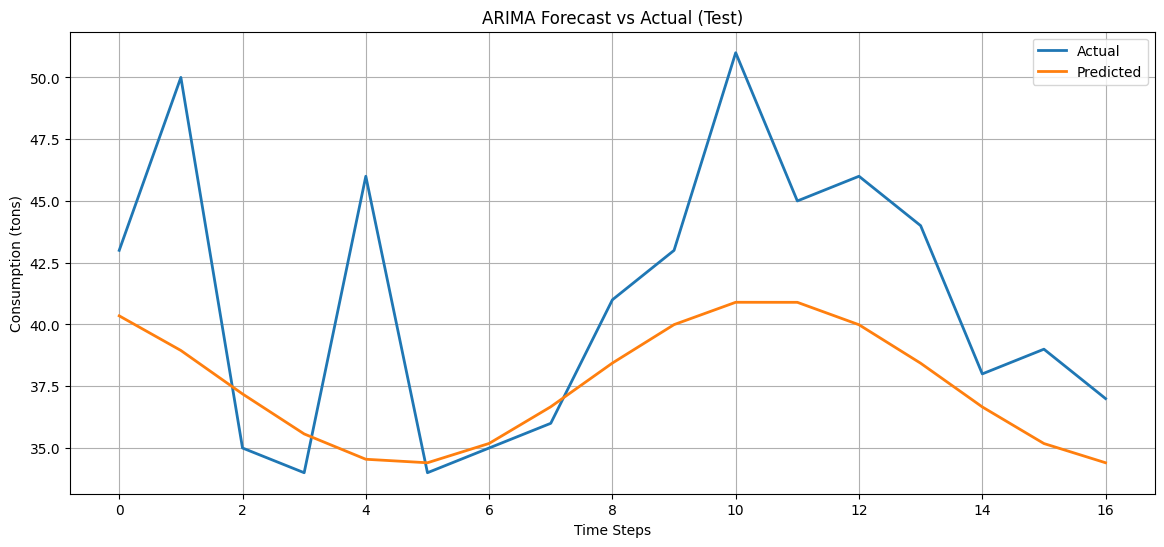

In [43]:
import matplotlib.pyplot as plt
import numpy as np

actual = y_test.values
predicted = y_forecast.values

plt.figure(figsize=(14,6))

plt.plot(actual, label="Actual", linewidth=2)
plt.plot(predicted, label="Predicted", linewidth=2)

plt.title("ARIMA Forecast vs Actual (Test)")
plt.xlabel("Time Steps")
plt.ylabel("Consumption (tons)")
plt.legend()
plt.grid(True)

plt.show()

## SARIMA 

In [44]:
warnings.filterwarnings("ignore")

def sarima_grid_search(y):
    y = pd.Series(y).dropna()
    s = 12

    p_values = range(0, 4)
    d_values = range(0, 3)
    q_values = range(0, 4)

    P_values = range(0, 3)
    D_values = range(0, 2)
    Q_values = range(0, 3)

    split_idx = int(len(y) * 0.8)
    X_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    results = []

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:

                            if (p, d, q) == (0, 0, 0) and (P, D, Q) == (0, 0, 0):
                                continue

                            try:
                                model = SARIMAX(
                                    X_train,
                                    order=(p, d, q),
                                    seasonal_order=(P, D, Q, s),
                                    trend=None,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                )
                                result = model.fit()

                                y_forecast = result.forecast(steps=len(y_test))
                                y_forecast.index = y_test.index
                            
                                mae = mean_absolute_error(y_test, y_forecast)
                                rmse = np.sqrt(mean_squared_error(y_test, y_forecast))

                                results.append({
                                    "order": (p, d, q),
                                    "seasonal_order": (P, D, Q, s),
                                    "mae": mae,
                                    "rmse": rmse
                                })
                            except:
                                continue

    results_df = pd.DataFrame(results)
    if results_df.empty:
        raise ValueError("No SARIMA models successfully fit. Try smaller ranges or check your series.")

    results_df = results_df.sort_values(by="mae", ascending=True).reset_index(drop=True)

    results_df[["p","d","q"]] = pd.DataFrame(results_df["order"].tolist(), index=results_df.index)
    results_df[["P","D","Q","s"]] = pd.DataFrame(results_df["seasonal_order"].tolist(), index=results_df.index)
    results_df = results_df.drop(columns=["order","seasonal_order"])

    best = results_df.iloc[0]
    best_nonseasonal = (int(best.p), int(best.d), int(best.q))
    best_seasonal = (int(best.P), int(best.D), int(best.Q), int(best.s))

    return best_nonseasonal, best_seasonal, results_df


In [ ]:
best_order, best_seasonal, sarima_results = sarima_grid_search(df_LSF["actual_consumption_tons"])

print("Best order:", best_order)
print("Best seasonal_order:", best_seasonal)

sarima_results.head()

In [ ]:
y = df_LSF["actual_consumption_tons"]
split_idx = int(len(y) * 0.8)
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

model = SARIMAX(
    y_train,
    order=(0,0,2),
    seasonal_order=(2,0,0,12),
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

y_forecast = results.forecast(steps=len(y_test))
y_forecast.index = y_test.index

print("Final MAE:", mean_absolute_error(y_test, y_forecast))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, y_forecast)))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

actual = y_test.values
predicted = y_forecast.values

plt.figure(figsize=(14,6))

plt.plot(actual, label="Actual", linewidth=2)
plt.plot(predicted, label="Predicted", linewidth=2)

plt.title("SARIMA Forecast vs Actual (Test)")
plt.xlabel("Time Steps")
plt.ylabel("Consumption (tons)")
plt.legend()
plt.grid(True)

plt.show()

## SARIMAX

In [45]:
warnings.filterwarnings("ignore")

def sarimax_grid_search(df, target_col="actual_consumption_tons", s=12):
    
    exog_cols = [
        "is_peak_construction_season",
        "confirmed_contract_volume_tons",
        "project_based_demand_flag",
        "number_of_active_projects",
        "raw_material_price_index",
        "energy_cost_index",
        "demand_growth_trend_index",
        "demand_volatility_index"
    ]

   
    y = df[target_col].astype(float)
    X = df[exog_cols].astype(float)

    split_idx = int(len(df) * 0.8)
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]

    p_values = range(0, 4)
    d_values = range(0, 3)
    q_values = range(0, 4)

    P_values = range(0, 3)
    D_values = range(0, 2)
    Q_values = range(0, 3)

    results = []

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:

                            if (p, d, q) == (0, 0, 0) and (P, D, Q) == (0, 0, 0):
                                continue

                            try:
                                model = SARIMAX(
                                    y_train,
                                    exog=X_train,
                                    order=(p, d, q),
                                    seasonal_order=(P, D, Q, s),
                                    trend=None,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                )
                                fit = model.fit(disp=False)

                                forecast = fit.forecast(steps=len(y_test), exog=X_test)
                                mae = mean_absolute_error(y_test, forecast)
                                rmse = np.sqrt(mean_squared_error(y_test, forecast))

                                results.append({
                                    "order": (p, d, q),
                                    "seasonal_order": (P, D, Q, s),
                                    "mae": mae,
                                    "rmse": rmse,
                                })
                            except:
                                continue

    results_df = pd.DataFrame(results)
    if results_df.empty:
        raise ValueError("No SARIMAX models successfully fit. Try smaller ranges or check your series.")

    results_df = results_df.sort_values(by="mae", ascending=True).reset_index(drop=True)

    results_df[["p","d","q"]] = pd.DataFrame(results_df["order"].tolist(), index=results_df.index)
    results_df[["P","D","Q","s"]] = pd.DataFrame(results_df["seasonal_order"].tolist(), index=results_df.index)
    results_df = results_df.drop(columns=["order","seasonal_order"])

    best = results_df.iloc[0]
    best_order = (int(best.p), int(best.d), int(best.q))
    best_seasonal = (int(best.P), int(best.D), int(best.Q), int(best.s))

    return best_order, best_seasonal, results_df, exog_cols


In [ ]:
best_order, best_seasonal, sarimax_results, exog_cols = sarimax_grid_search(df_LSF)

print("Best SARIMAX order:", best_order)
print("Best SARIMAX seasonal_order:", best_seasonal)

sarimax_results.to_csv("sarimax_grid_results.csv", index=False)
sarimax_results.head(10)


In [ ]:
target = "actual_consumption_tons"

y = df_LSF[target].astype(float)
X = df_LSF[exog_cols].astype(float)

split_idx = int(len(df_LSF) * 0.8)
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]

final_model = SARIMAX(
    y_train,
    exog=X_train,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_fit = final_model.fit(disp=False)

y_forecast = final_fit.forecast(steps=len(y_test), exog=X_test)

print("Final MAE:", mean_absolute_error(y_test, y_forecast))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, y_forecast)))


In [ ]:
actual = y_test.values
predicted = y_forecast.values

plt.figure(figsize=(14,6))

plt.plot(actual, label="Actual", linewidth=2)
plt.plot(predicted, label="Predicted", linewidth=2)

plt.title("SARIMAX Forecast vs Actual (Test)")
plt.xlabel("Time Steps")
plt.ylabel("Consumption (tons)")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
warnings.filterwarnings("ignore")

df_LSF = df[df["material_name"] == "LSF"]

In [ ]:
df_LSF.info()

# LSF

## Predicting Raw Material Price

In [172]:
best_order, best_seasonal, sarima_results = sarima_grid_search(df_LSF["raw_material_price_index"])

print("Best order:", best_order)
print("Best seasonal_order:", best_seasonal)

sarima_results.head()

Best order: (2, 2, 3)
Best seasonal_order: (0, 1, 0, 12)


,mae,rmse,p,d,q,P,D,Q,s
0,0.739826,1.014984,2,2,3,0,1,0,12
1,0.756447,1.027569,2,1,2,0,1,0,12
2,0.871115,1.184289,2,2,0,0,1,0,12
3,0.875999,1.208939,3,2,0,0,1,0,12
4,0.904147,1.188566,2,2,2,0,1,0,12


In [173]:
y = df_LSF["raw_material_price_index"]
split_idx = int(len(y) * 0.8)
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

model = SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

y_forecast = results.forecast(steps=len(y_test))
y_forecast.index = y_test.index

print("Final MAE:", mean_absolute_error(y_test, y_forecast))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, y_forecast)))


Final MAE: 0.7398256211337568
Final RMSE: 1.0149836095568707


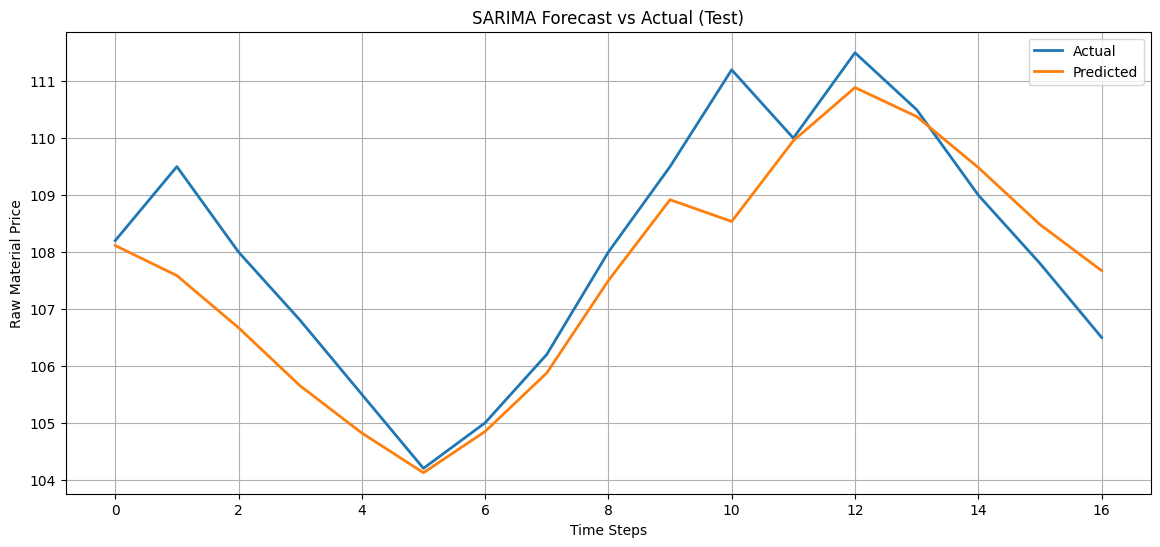

In [174]:
actual = y_test.values
predicted = y_forecast.values

plt.figure(figsize=(14,6))

plt.plot(actual, label="Actual", linewidth=2)
plt.plot(predicted, label="Predicted", linewidth=2)

plt.title("SARIMA Forecast vs Actual (Test)")
plt.xlabel("Time Steps")
plt.ylabel("Raw Material Price")
plt.legend()
plt.grid(True)

plt.show()

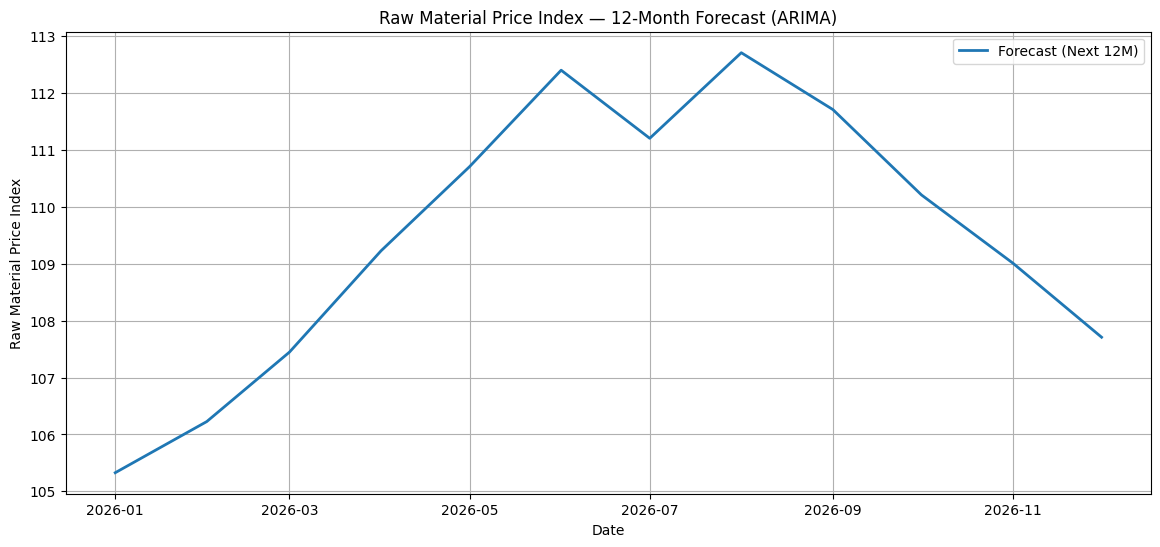

In [175]:
y = df_LSF["raw_material_price_index"].astype(float)

model = SARIMAX( y ,order=(2,2,3), seasonal_order=(0,1,0,12), trend=None, enforce_stationarity=False, enforce_invertibility=False)
fit = model.fit()

future_price = fit.forecast(steps=12)

# convert ONLY the last index value (no dataset change)
last_date = pd.to_datetime(df_LSF.index[-1])

future_price.index = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=12,
    freq="MS"
)

# ---- Plot forecast only
plt.figure(figsize=(14,6))
plt.plot(future_price.index, future_price.values, label="Forecast (Next 12M)", linewidth=2)
plt.title("Raw Material Price Index — 12-Month Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Raw Material Price Index")
plt.legend()
plt.grid(True)
plt.show()


## Predicting Energy Cost

In [176]:
best_order, best_seasonal, sarima_results = sarima_grid_search(df_LSF["energy_cost_index"])

print("Best order:", best_order)
print("Best seasonal_order:", best_seasonal)

sarima_results.head()

Best order: (2, 2, 3)
Best seasonal_order: (0, 1, 0, 12)


,mae,rmse,p,d,q,P,D,Q,s
0,0.553518,0.753634,2,2,3,0,1,0,12
1,0.571494,0.768443,3,1,2,0,1,0,12
2,0.591450,0.783384,2,1,2,0,1,0,12
3,0.632638,0.752767,2,0,1,0,1,0,12
4,0.663961,0.815142,2,2,2,0,1,0,12


In [177]:
y = df_LSF["energy_cost_index"]
split_idx = int(len(y) * 0.8)
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

model = SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

y_forecast = results.forecast(steps=len(y_test))
y_forecast.index = y_test.index

print("Final MAE:", mean_absolute_error(y_test, y_forecast))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, y_forecast)))


Final MAE: 0.553518077075402
Final RMSE: 0.7536338979509661


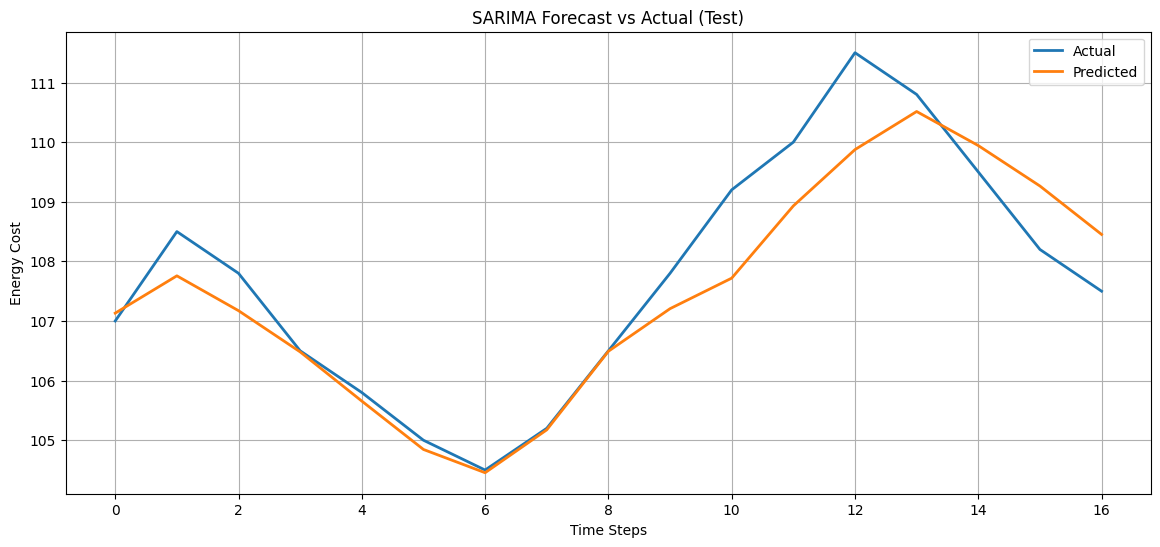

In [178]:
actual = y_test.values
predicted = y_forecast.values

plt.figure(figsize=(14,6))

plt.plot(actual, label="Actual", linewidth=2)
plt.plot(predicted, label="Predicted", linewidth=2)

plt.title("SARIMA Forecast vs Actual (Test)")
plt.xlabel("Time Steps")
plt.ylabel("Energy Cost")
plt.legend()
plt.grid(True)

plt.show()

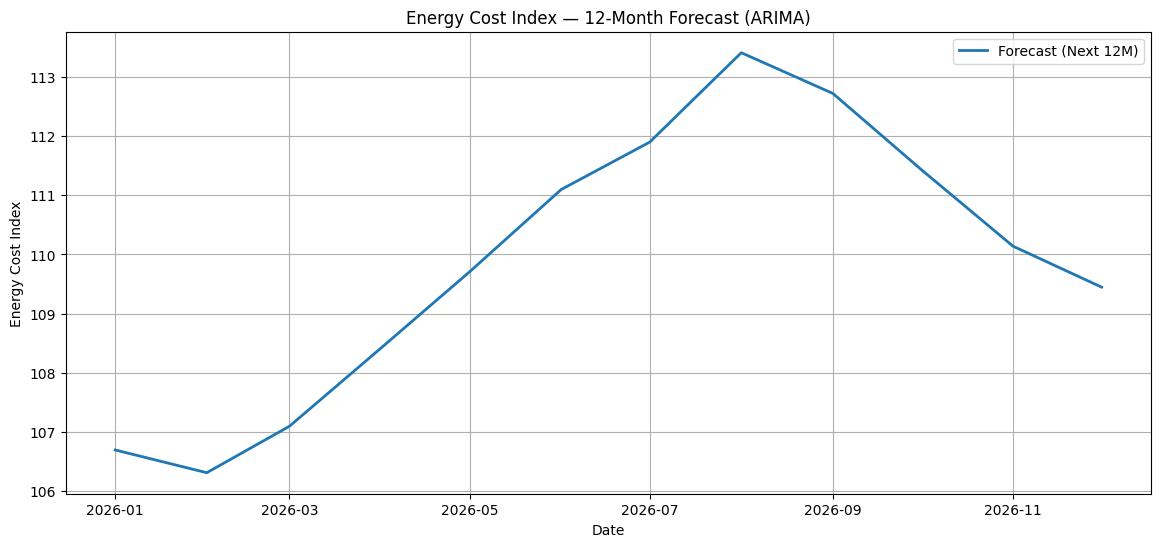

In [179]:
y = df_LSF["energy_cost_index"].astype(float)

model = SARIMAX(
    y,
    order=(2,2,3),
    seasonal_order=(0,1,0,12),
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
fit = model.fit()

future_energy = fit.forecast(steps=12)

# convert ONLY the last index value (no dataset change)
last_date = pd.to_datetime(df_LSF.index[-1])

future_energy.index = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=12,
    freq="MS"
)

# ---- Plot forecast only
plt.figure(figsize=(14,6))
plt.plot(future_energy.index, future_energy.values, label="Forecast (Next 12M)", linewidth=2)
plt.title("Energy Cost Index — 12-Month Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Energy Cost Index")
plt.legend()
plt.grid(True)
plt.show()


## Predicting Future Demand

In [180]:
warnings.filterwarnings("ignore")

H = 12
target = "actual_consumption_tons"

exog_cols = [
    "is_peak_construction_season",
    "confirmed_contract_volume_tons",
    "project_based_demand_flag",
    "number_of_active_projects",
    "raw_material_price_index",
    "energy_cost_index",
    "demand_growth_trend_index",
    "demand_volatility_index"
]

In [228]:
from sklearn.preprocessing import RobustScaler

binary_cols = [
    "is_peak_construction_season",
    "project_based_demand_flag"
]

scale_cols = [
    "confirmed_contract_volume_tons",
    "number_of_active_projects",
    "raw_material_price_index",
    "energy_cost_index",
    "demand_growth_trend_index",
    "demand_volatility_index"
]

exog_cols = binary_cols + scale_cols

split_idx = int(len(df_LSF) * 0.8)

train_exog = df_LSF.iloc[:split_idx][exog_cols].copy()
test_exog  = df_LSF.iloc[split_idx:][exog_cols].copy()

scaler = RobustScaler(quantile_range=(25, 75))
scaler.fit(train_exog[scale_cols])

# work on a copy (doesn't touch df_LSF)
df_model = df_LSF.copy()
df_model[scale_cols] = scaler.transform(df_model[scale_cols])

In [182]:
best_order, best_seasonal, sarimax_results, exog_cols = sarimax_grid_search(df_model)

print("Best SARIMAX order:", best_order)
print("Best SARIMAX seasonal_order:", best_seasonal)

sarimax_results.head(10)


Best SARIMAX order: (2, 1, 3)
Best SARIMAX seasonal_order: (0, 0, 0, 12)


,mae,rmse,p,d,q,P,D,Q,s
0,0.667815,0.902390,2,1,3,0,0,0,12
1,0.687710,1.002969,2,1,1,1,0,0,12
2,0.728433,1.044069,1,1,3,1,0,0,12
3,0.738625,1.245073,0,1,0,0,1,1,12
4,0.740110,1.056561,0,1,3,1,0,0,12
5,0.751188,1.010444,3,1,0,0,0,1,12
6,0.752172,0.995159,3,1,1,0,0,0,12
7,0.757780,1.081812,1,1,2,1,0,0,12
8,0.760571,1.293422,1,1,0,0,1,1,12
9,0.762389,0.998678,3,1,0,0,0,0,12


In [229]:
y_full = df_model[target].astype(float)
X_full = df_model[exog_cols].astype(float)

full_model = SARIMAX(
    y_full,
    exog=X_full,
    order=(2,1,3),
    seasonal_order=(0,0,0,12),
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
full_fit = full_model.fit(disp=False)


In [230]:
H = 12

# --- safe future index WITHOUT changing df_LSF
last_date = pd.to_datetime(df_LSF.index[-1])
future_index = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=H,
    freq="MS"
)

# ----------------------------
# 1) Build future_exog (UNSCALED)
# ----------------------------
future_exog = pd.DataFrame(index=future_index)

is_peak_construction_season = [0,0,0,0,1,1,1,1,0,0,0,0]
confirmed_contract_volume_tons = [0,0,1,1,2,6,5,4,1,1,0,0]

# this should be a FLAG (0/1). If you meant intensity, rename the column.
project_based_demand_flag = [0,0,1,1,1,1,1,1,0,0,0,0]

number_of_active_projects = [0,1,2,2,2,3,3,2,2,2,1,0]

# manual inputs (must be length 12)
future_exog["is_peak_construction_season"]     = is_peak_construction_season
future_exog["confirmed_contract_volume_tons"]  = confirmed_contract_volume_tons
future_exog["project_based_demand_flag"]       = project_based_demand_flag
future_exog["number_of_active_projects"]       = number_of_active_projects

# price/energy forecasts (force to 1D & align)
future_price_series  = pd.Series(np.array(future_price).reshape(-1),  index=future_index)
future_energy_series = pd.Series(np.array(future_energy).reshape(-1), index=future_index)

future_exog["raw_material_price_index"] = future_price_series.values
future_exog["energy_cost_index"]        = future_energy_series.values

# placeholders for growth/volatility (seasonal averages from history)
df_tmp = df_LSF.copy()
df_tmp.index = pd.to_datetime(df_tmp.index)

growth_by_month = df_tmp.groupby(df_tmp.index.month)["demand_growth_trend_index"].mean()
vol_by_month    = df_tmp.groupby(df_tmp.index.month)["demand_volatility_index"].mean()

future_exog["demand_growth_trend_index"] = [float(growth_by_month[d.month]) for d in future_index]
future_exog["demand_volatility_index"]   = [float(vol_by_month[d.month])    for d in future_index]

# enforce correct order + float
future_exog = future_exog[exog_cols].astype(float)

# ----------------------------
# 2) SCALE future_exog using the SAME fitted scaler (DO NOT FIT AGAIN)
# ----------------------------
future_exog_s = future_exog.copy()
future_exog_s[scale_cols] = scaler.transform(future_exog_s[scale_cols])

# ----------------------------
# 3) Forecast next 12 months using your trained model
# ----------------------------
future_demand_forecast = full_fit.forecast(steps=H, exog=future_exog_s)
future_demand_forecast = pd.Series(future_demand_forecast.values, index=future_index, name="forecast")

# (optional) clip negative demand if you want
future_demand_forecast = future_demand_forecast.clip(lower=0)

future_demand_forecast

2026-01-01    32.948023
2026-02-01    33.197049
2026-03-01    33.040595
2026-04-01    34.627767
2026-05-01    36.285296
2026-06-01    39.141923
2026-07-01    40.044916
2026-08-01    39.819323
2026-09-01    39.133153
2026-10-01    34.107514
2026-11-01    33.482163
2026-12-01    34.523968
Freq: MS, Name: forecast, dtype: float64

In [231]:
df_LSF = df[df["material_name"] == "LSF"].copy()

KeyError: 'material_name'

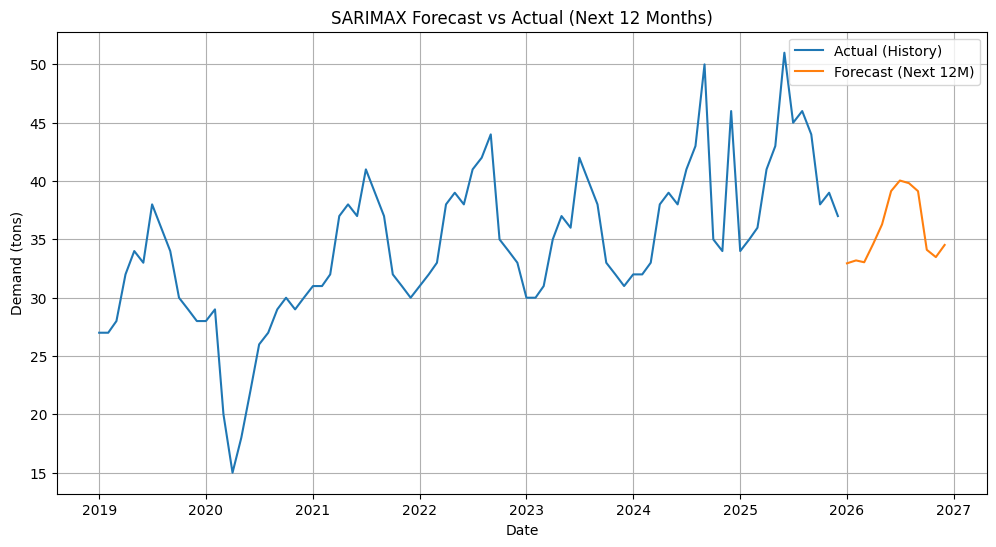

,date,forecast_demand_tons
0,2026-01-01,32.948023
1,2026-02-01,33.197049
2,2026-03-01,33.040595
3,2026-04-01,34.627767
4,2026-05-01,36.285296
5,2026-06-01,39.141923
6,2026-07-01,40.044916
7,2026-08-01,39.819323
8,2026-09-01,39.133153
9,2026-10-01,34.107514


In [232]:
# ---- SAFE PLOT (fixes tz / UnitData error) ----

hist_x = pd.to_datetime(df_LSF.index)
fut_x  = pd.to_datetime(future_demand_forecast.index)

plt.figure(figsize=(12, 6))

plt.plot(hist_x, df_LSF["actual_consumption_tons"].values, label="Actual (History)")
plt.plot(fut_x, future_demand_forecast.values, label="Forecast (Next 12M)")

plt.title("SARIMAX Forecast vs Actual (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Demand (tons)")
plt.legend()
plt.grid(True)

plt.show()

# ----------------------------
# 5) Export forecast
# ----------------------------
forecast_df = future_demand_forecast.reset_index()
forecast_df.columns = ["date", "forecast_demand_tons"]
forecast_df.to_csv("Forecast_LSF.csv", index=False)

forecast_df.head(12)

# PVC

## EDA

In [ ]:
df_PVC.info()

In [ ]:
df_PVC = df_PVC.drop(columns=["material_name", "quarter", "month"])

In [ ]:
train_size = int(0.8 * len(df_PVC))

test_size = len(df_PVC) - train_size

print(f"Train size: {train_size}")
print(f"Test size: {test_size}")

In [ ]:
data = df_PVC.values
train = data[:train_size, :]

test = data[train_size-12:, :]

In [ ]:
feature_cols = [c for c in df_PVC.columns if c != "actual_consumption_tons"]

train_size = int(0.8 * len(df_PVC))
train_df = df_PVC.iloc[:train_size]
test_df  = df_PVC.iloc[train_size:]

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = x_scaler.fit_transform(train_df[feature_cols])
X_test_scaled  = x_scaler.transform(test_df[feature_cols])

y_train_scaled = y_scaler.fit_transform(train_df[["actual_consumption_tons"]]).ravel()
y_test_scaled  = y_scaler.transform(test_df[["actual_consumption_tons"]]).ravel()


In [ ]:
best_order, best_seasonal, sarima_results = sarima_grid_search(df_PVC["actual_consumption_tons"])

print("Best order:", best_order)
print("Best seasonal_order:", best_seasonal)

sarima_results.head()

## SARIMAX Model

In [ ]:
best_order, best_seasonal, sarimax_results, exog_cols = sarimax_grid_search(df_PVC)

print("Best SARIMAX order:", best_order)
print("Best SARIMAX seasonal_order:", best_seasonal)

sarimax_results.to_csv("sarimax_grid_results.csv", index=False)
sarimax_results.head(10)


In [ ]:
target = "actual_consumption_tons"

y = df_PVC[target].astype(float)
X = df_PVC[exog_cols].astype(float)

split_idx = int(len(df_PVC) * 0.8)
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]

final_model = SARIMAX(
    y_train,
    exog=X_train,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_fit = final_model.fit(disp=False)

y_forecast = final_fit.forecast(steps=len(y_test), exog=X_test)

print("Final MAE:", mean_absolute_error(y_test, y_forecast))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, y_forecast)))


In [ ]:
actual = y_test.values
predicted = y_forecast.values

plt.figure(figsize=(14,6))

plt.plot(actual, label="Actual", linewidth=2)
plt.plot(predicted, label="Predicted", linewidth=2)

plt.title("SARIMAX Forecast vs Actual (Test)")
plt.xlabel("Time Steps")
plt.ylabel("Consumption (tons)")
plt.legend()
plt.grid(True)

plt.show()

## Predicting Future Price

In [186]:
best_order, best_seasonal, sarima_results = sarima_grid_search(df_PVC["raw_material_price_index"])

print("Best order:", best_order)
print("Best seasonal_order:", best_seasonal)

sarima_results.head()

Best order: (2, 0, 1)
Best seasonal_order: (0, 1, 0, 12)


,mae,rmse,p,d,q,P,D,Q,s
0,0.917239,1.041273,2,0,1,0,1,0,12
1,1.068627,1.402186,2,0,0,1,1,2,12
2,1.113255,1.331788,2,2,2,2,1,2,12
3,1.124862,1.350840,0,2,2,2,1,2,12
4,1.127929,1.440535,0,0,3,1,0,2,12


In [187]:
y = df_PVC["raw_material_price_index"]
split_idx = int(len(y) * 0.8)
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

model = SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

y_forecast = results.forecast(steps=len(y_test))
y_forecast.index = y_test.index

print("Final MAE:", mean_absolute_error(y_test, y_forecast))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, y_forecast)))


Final MAE: 0.9172391851486051
Final RMSE: 1.0412733532250698


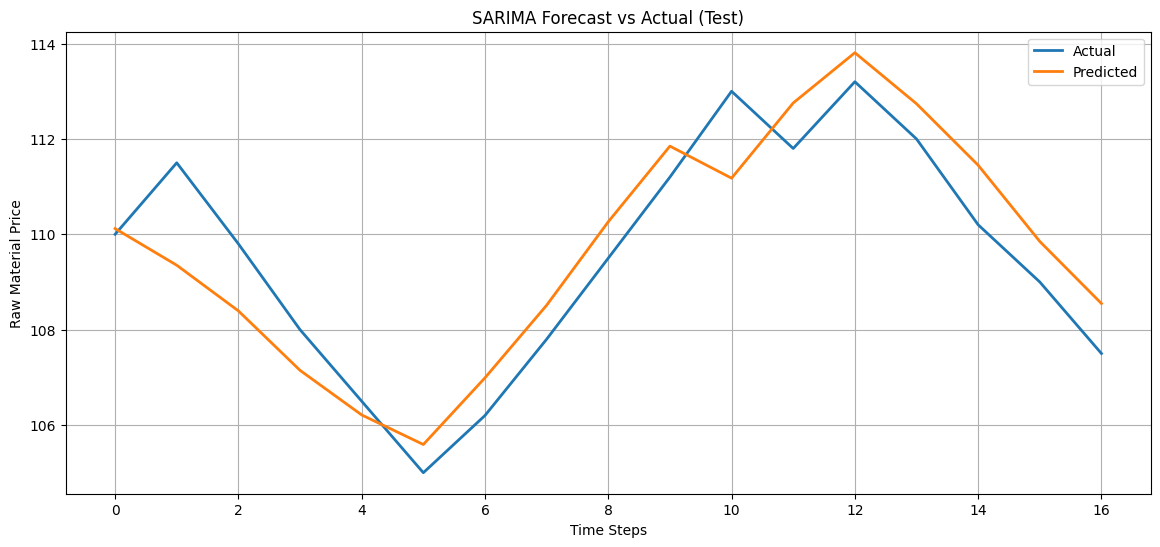

In [188]:
actual = y_test.values
predicted = y_forecast.values

plt.figure(figsize=(14,6))

plt.plot(actual, label="Actual", linewidth=2)
plt.plot(predicted, label="Predicted", linewidth=2)

plt.title("SARIMA Forecast vs Actual (Test)")
plt.xlabel("Time Steps")
plt.ylabel("Raw Material Price")
plt.legend()
plt.grid(True)

plt.show()

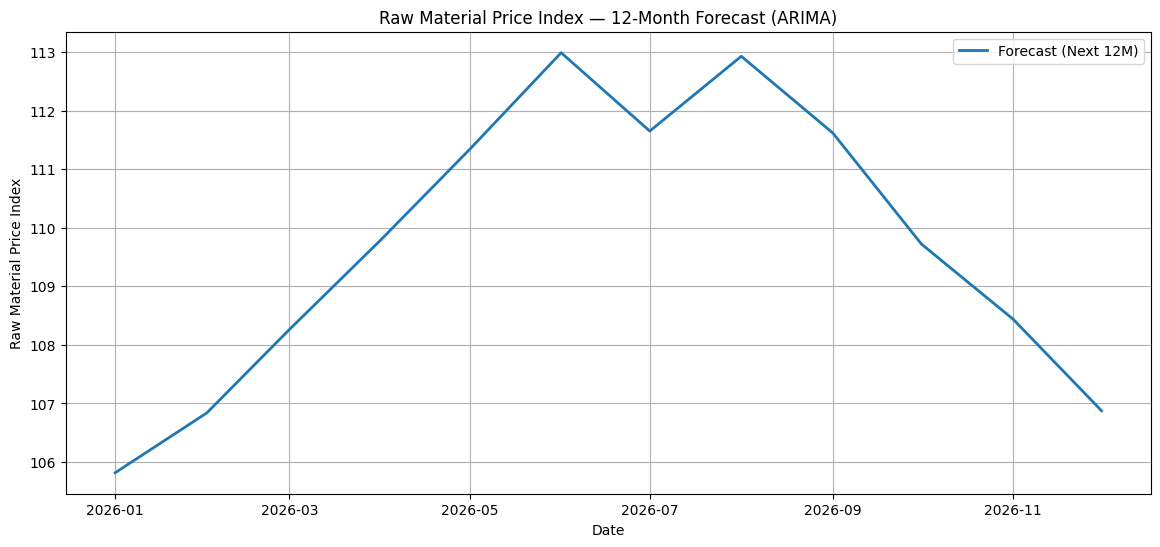

In [189]:
y = df_PVC["raw_material_price_index"].astype(float)

model = SARIMAX( y ,order=best_order, seasonal_order=best_seasonal, trend=None, enforce_stationarity=False, enforce_invertibility=False)
fit = model.fit()

future_price = fit.forecast(steps=12)

# convert ONLY the last index value (no dataset change)
last_date = pd.to_datetime(df_PVC.index[-1])

future_price.index = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=12,
    freq="MS"
)

# ---- Plot forecast only
plt.figure(figsize=(14,6))
plt.plot(future_price.index, future_price.values, label="Forecast (Next 12M)", linewidth=2)
plt.title("Raw Material Price Index — 12-Month Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Raw Material Price Index")
plt.legend()
plt.grid(True)
plt.show()


## Predicting Future Energy

In [190]:
best_order, best_seasonal, sarima_results = sarima_grid_search(df_PVC["energy_cost_index"])

print("Best order:", best_order)
print("Best seasonal_order:", best_seasonal)

sarima_results.head()

Best order: (2, 2, 3)
Best seasonal_order: (0, 1, 0, 12)


,mae,rmse,p,d,q,P,D,Q,s
0,0.553518,0.753634,2,2,3,0,1,0,12
1,0.571494,0.768443,3,1,2,0,1,0,12
2,0.591450,0.783384,2,1,2,0,1,0,12
3,0.632638,0.752767,2,0,1,0,1,0,12
4,0.663961,0.815142,2,2,2,0,1,0,12


In [191]:
y = df_PVC["energy_cost_index"]
split_idx = int(len(y) * 0.8)
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

model = SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

y_forecast = results.forecast(steps=len(y_test))
y_forecast.index = y_test.index

print("Final MAE:", mean_absolute_error(y_test, y_forecast))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, y_forecast)))


Final MAE: 0.553518077075402
Final RMSE: 0.7536338979509661


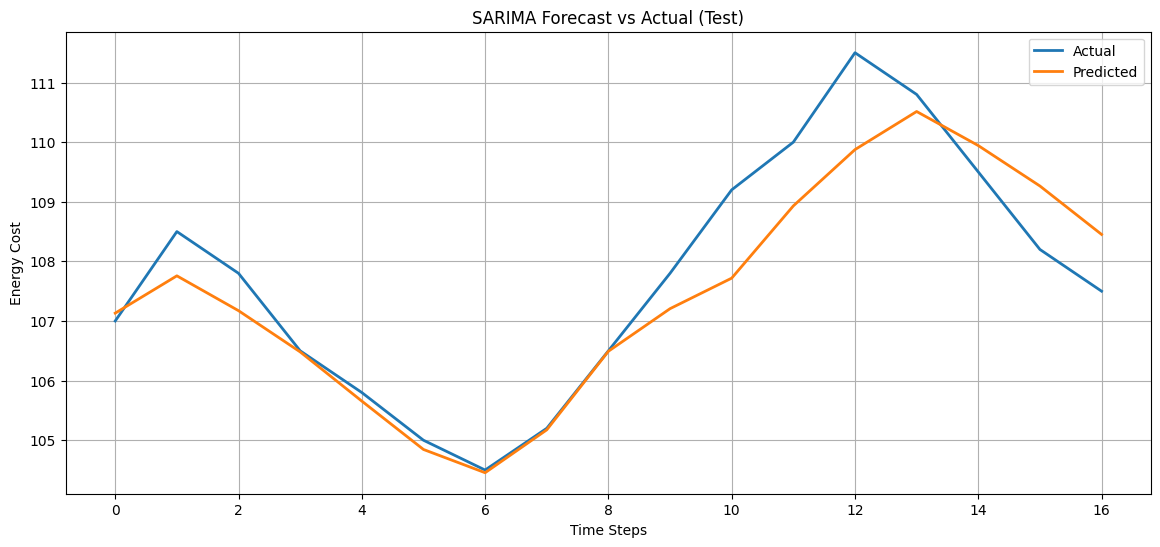

In [192]:
actual = y_test.values
predicted = y_forecast.values

plt.figure(figsize=(14,6))

plt.plot(actual, label="Actual", linewidth=2)
plt.plot(predicted, label="Predicted", linewidth=2)

plt.title("SARIMA Forecast vs Actual (Test)")
plt.xlabel("Time Steps")
plt.ylabel("Energy Cost")
plt.legend()
plt.grid(True)

plt.show()

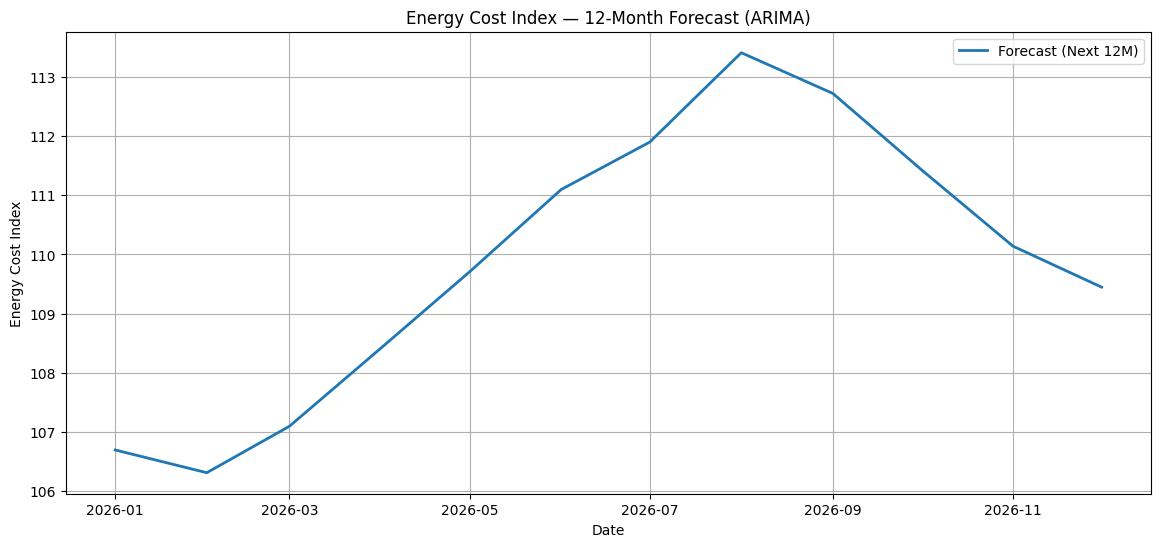

In [193]:
y = df_PVC["energy_cost_index"].astype(float)

model = SARIMAX(
    y,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
fit = model.fit()

future_energy = fit.forecast(steps=12)

# convert ONLY the last index value (no dataset change)
last_date = pd.to_datetime(df_PVC.index[-1])

future_energy.index = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=12,
    freq="MS"
)

# ---- Plot forecast only
plt.figure(figsize=(14,6))
plt.plot(future_energy.index, future_energy.values, label="Forecast (Next 12M)", linewidth=2)
plt.title("Energy Cost Index — 12-Month Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Energy Cost Index")
plt.legend()
plt.grid(True)
plt.show()


## Predicting Future Demand

In [233]:
from sklearn.preprocessing import RobustScaler

binary_cols = [
    "is_peak_construction_season",
    "project_based_demand_flag"
]

scale_cols = [
    "confirmed_contract_volume_tons",
    "number_of_active_projects",
    "raw_material_price_index",
    "energy_cost_index",
    "demand_growth_trend_index",
    "demand_volatility_index"
]

exog_cols = binary_cols + scale_cols

split_idx = int(len(df_PVC) * 0.8)

train_exog = df_PVC.iloc[:split_idx][exog_cols].copy()
test_exog  = df_PVC.iloc[split_idx:][exog_cols].copy()

scaler = RobustScaler(quantile_range=(25, 75))
scaler.fit(train_exog[scale_cols])

df_model = df_PVC.copy()
df_model[scale_cols] = scaler.transform(df_model[scale_cols])

In [195]:
best_order, best_seasonal, sarimax_results, exog_cols = sarimax_grid_search(df_model)

print("Best SARIMAX order:", best_order)
print("Best SARIMAX seasonal_order:", best_seasonal)

sarimax_results.to_csv("sarimax_grid_results.csv", index=False)
sarimax_results.head(10)


Best SARIMAX order: (0, 1, 2)
Best SARIMAX seasonal_order: (0, 1, 0, 12)


,mae,rmse,p,d,q,P,D,Q,s
0,2.271490,3.411759,0,1,2,0,1,0,12
1,2.282672,3.213146,0,1,0,0,1,0,12
2,2.334275,3.648989,3,1,0,0,1,0,12
3,2.342679,3.429845,3,1,2,0,1,0,12
4,2.375083,3.667806,3,1,1,0,1,0,12
5,2.418158,3.208298,1,0,0,0,1,0,12
6,2.421493,3.429105,2,2,1,0,1,0,12
7,2.462900,3.289663,1,0,1,0,1,0,12
8,2.490223,3.390373,1,1,0,0,1,0,12
9,2.499586,3.498985,2,2,2,0,1,0,12


In [234]:
y_full = df_model[target].astype(float)
X_full = df_model[exog_cols].astype(float)

full_model = SARIMAX(
    y_full,
    exog=X_full,
    order=(0,1,2),
    seasonal_order=(0,1,0,12),
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
full_fit = full_model.fit(disp=False)


In [235]:
H = 12

last_date = pd.to_datetime(df_PVC.index[-1])
future_index = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=H,
    freq="MS"
)

# ----------------------------
# 1) Build future_exog (UNSCALED)
# ----------------------------
future_exog = pd.DataFrame(index=future_index)

last_12 = df_PVC.tail(12)

is_peak_construction_season = last_12['is_peak_construction_season'].tolist()
confirmed_contract_volume_tons = last_12['confirmed_contract_volume_tons'].tolist()
project_based_demand_flag = last_12['project_based_demand_flag'].tolist()
number_of_active_projects = last_12['number_of_active_projects'].tolist()

# manual inputs (must be length 12)
future_exog["is_peak_construction_season"]     = is_peak_construction_season
future_exog["confirmed_contract_volume_tons"]  = confirmed_contract_volume_tons
future_exog["project_based_demand_flag"]       = project_based_demand_flag
future_exog["number_of_active_projects"]       = number_of_active_projects

# price/energy forecasts (force to 1D & align)
future_price_series  = pd.Series(np.array(future_price).reshape(-1),  index=future_index)
future_energy_series = pd.Series(np.array(future_energy).reshape(-1), index=future_index)

future_exog["raw_material_price_index"] = future_price_series.values
future_exog["energy_cost_index"]        = future_energy_series.values

# placeholders for growth/volatility (seasonal averages from history)
df_tmp = df_PVC.copy()
df_tmp.index = pd.to_datetime(df_tmp.index)

growth_by_month = df_tmp.groupby(df_tmp.index.month)["demand_growth_trend_index"].mean()
vol_by_month    = df_tmp.groupby(df_tmp.index.month)["demand_volatility_index"].mean()

future_exog["demand_growth_trend_index"] = [float(growth_by_month[d.month]) for d in future_index]
future_exog["demand_volatility_index"]   = [float(vol_by_month[d.month])    for d in future_index]

# enforce correct order + float
future_exog = future_exog[exog_cols].astype(float)

# ----------------------------
# 2) SCALE future_exog using the SAME fitted scaler (DO NOT FIT AGAIN)
# ----------------------------
future_exog_s = future_exog.copy()
future_exog_s[scale_cols] = scaler.transform(future_exog_s[scale_cols])

# ----------------------------
# 3) Forecast next 12 months using your trained model
# ----------------------------
future_demand_forecast = full_fit.forecast(steps=H, exog=future_exog_s)
future_demand_forecast = pd.Series(future_demand_forecast.values, index=future_index, name="forecast")

# (optional) clip negative demand if you want
future_demand_forecast = future_demand_forecast.clip(lower=0)

future_demand_forecast

2026-01-01    131.405355
2026-02-01    134.994487
2026-03-01    133.390513
2026-04-01    146.905246
2026-05-01    153.852247
2026-06-01    167.031415
2026-07-01    164.952148
2026-08-01    166.269660
2026-09-01    168.204921
2026-10-01    142.364340
2026-11-01    141.607493
2026-12-01    142.966413
Freq: MS, Name: forecast, dtype: float64

In [236]:
df_PVC = df[df["material_name"] == "PVC"].copy()

KeyError: 'material_name'

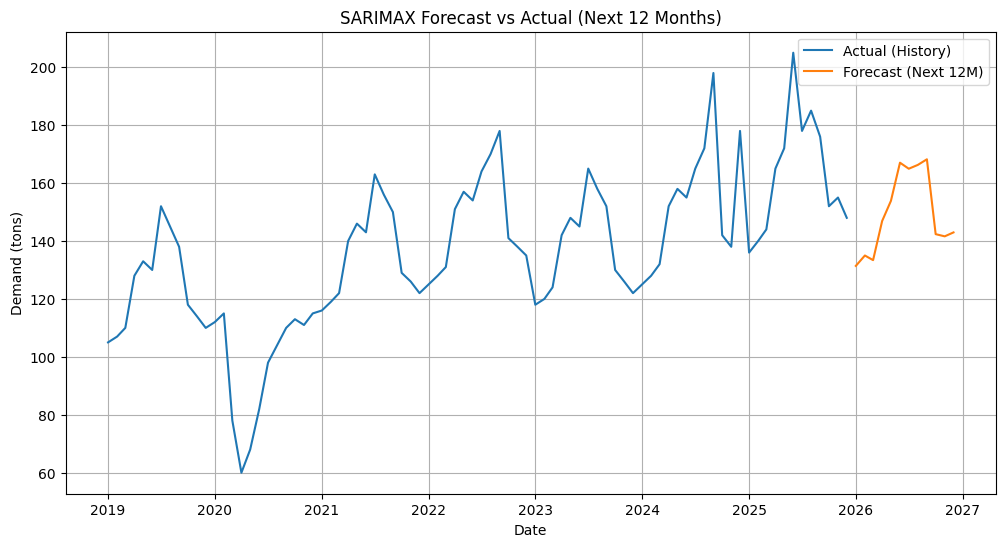

,date,forecast_demand_tons
0,2026-01-01,131.405355
1,2026-02-01,134.994487
2,2026-03-01,133.390513
3,2026-04-01,146.905246
4,2026-05-01,153.852247
5,2026-06-01,167.031415
6,2026-07-01,164.952148
7,2026-08-01,166.269660
8,2026-09-01,168.204921
9,2026-10-01,142.364340


In [237]:
# ---- SAFE PLOT (fixes tz / UnitData error) ----

hist_x = pd.to_datetime(df_PVC.index)
fut_x  = pd.to_datetime(future_demand_forecast.index)

plt.figure(figsize=(12, 6))

plt.plot(hist_x, df_PVC["actual_consumption_tons"].values, label="Actual (History)")
plt.plot(fut_x, future_demand_forecast.values, label="Forecast (Next 12M)")

plt.title("SARIMAX Forecast vs Actual (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Demand (tons)")
plt.legend()
plt.grid(True)

plt.show()

# ----------------------------
# 5) Export forecast
# ----------------------------
forecast_df = future_demand_forecast.reset_index()
forecast_df.columns = ["date", "forecast_demand_tons"]
forecast_df.to_csv("Forecast_PVC.csv", index=False)

forecast_df.head(12)

# PE

## EDA

In [95]:
df_PE.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84 entries, 1/1/2019 to 12/1/2025
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   material_name                   84 non-null     object 
 1   actual_consumption_tons         84 non-null     int64  
 2   month                           84 non-null     int64  
 3   quarter                         84 non-null     int64  
 4   is_peak_construction_season     84 non-null     int64  
 5   confirmed_contract_volume_tons  84 non-null     int64  
 6   project_based_demand_flag       84 non-null     int64  
 7   number_of_active_projects       84 non-null     int64  
 8   raw_material_price_index        84 non-null     float64
 9   energy_cost_index               84 non-null     float64
 10  demand_growth_trend_index       84 non-null     float64
 11  demand_volatility_index         84 non-null     float64
dtypes: float64(4), int64(7), obje

In [96]:
df_PE = df_PE.drop(columns=["material_name", "quarter", "month"])

In [97]:
train_size = int(0.8 * len(df_PE))

test_size = len(df_PE) - train_size

print(f"Train size: {train_size}")
print(f"Test size: {test_size}")

Train size: 67
Test size: 17


In [98]:
data = df_PE.values
train = data[:train_size, :]

test = data[train_size-12:, :]

In [99]:
feature_cols = [c for c in df_PE.columns if c != "actual_consumption_tons"]

train_size = int(0.8 * len(df_PE))
train_df = df_PE.iloc[:train_size]
test_df  = df_PE.iloc[train_size:]

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = x_scaler.fit_transform(train_df[feature_cols])
X_test_scaled  = x_scaler.transform(test_df[feature_cols])

y_train_scaled = y_scaler.fit_transform(train_df[["actual_consumption_tons"]]).ravel()
y_test_scaled  = y_scaler.transform(test_df[["actual_consumption_tons"]]).ravel()


<Axes: xlabel='date'>

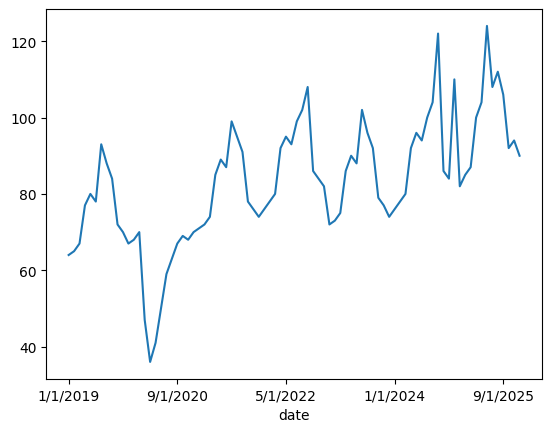

In [101]:
df_PE["actual_consumption_tons"].plot()

## SARIMAX Model

In [ ]:
best_order, best_seasonal, sarimax_results, exog_cols = sarimax_grid_search(df_PE)

print("Best SARIMAX order:", best_order)
print("Best SARIMAX seasonal_order:", best_seasonal)

sarimax_results.head(10)


In [ ]:
target = "actual_consumption_tons"

y = df_PE[target].astype(float)
X = df_PE[exog_cols].astype(float)

split_idx = int(len(df_PE) * 0.8)
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]

final_model = SARIMAX(
    y_train,
    exog=X_train,
    order=(2,1,2),
    seasonal_order=(0,1,0,12),
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_fit = final_model.fit(disp=False)

y_forecast = final_fit.forecast(steps=len(y_test), exog=X_test)

print("Final MAE:", mean_absolute_error(y_test, y_forecast))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, y_forecast)))


In [ ]:
actual = y_test.values
predicted = y_forecast.values

plt.figure(figsize=(14,6))

plt.plot(actual, label="Actual", linewidth=2)
plt.plot(predicted, label="Predicted", linewidth=2)

plt.title("SARIMAX Forecast vs Actual (Test)")
plt.xlabel("Time Steps")
plt.ylabel("Consumption (tons)")
plt.legend()
plt.grid(True)

plt.show()

## Predicting Future Price

In [200]:
best_order, best_seasonal, sarima_results = sarima_grid_search(df_PE["raw_material_price_index"])

print("Best order:", best_order)
print("Best seasonal_order:", best_seasonal)

sarima_results.head()

Best order: (2, 0, 0)
Best seasonal_order: (1, 1, 2, 12)


,mae,rmse,p,d,q,P,D,Q,s
0,1.069453,1.357442,2,0,0,1,1,2,12
1,1.075128,1.394847,1,0,2,1,1,2,12
2,1.127424,1.426536,1,0,1,1,1,2,12
3,1.186364,1.470991,0,0,3,1,0,2,12
4,1.232704,1.579509,2,0,3,1,1,2,12


In [201]:
y = df_PE["raw_material_price_index"]
split_idx = int(len(y) * 0.8)
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

model = SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

y_forecast = results.forecast(steps=len(y_test))
y_forecast.index = y_test.index

print("Final MAE:", mean_absolute_error(y_test, y_forecast))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, y_forecast)))


Final MAE: 1.0694525893768037
Final RMSE: 1.3574424363904865


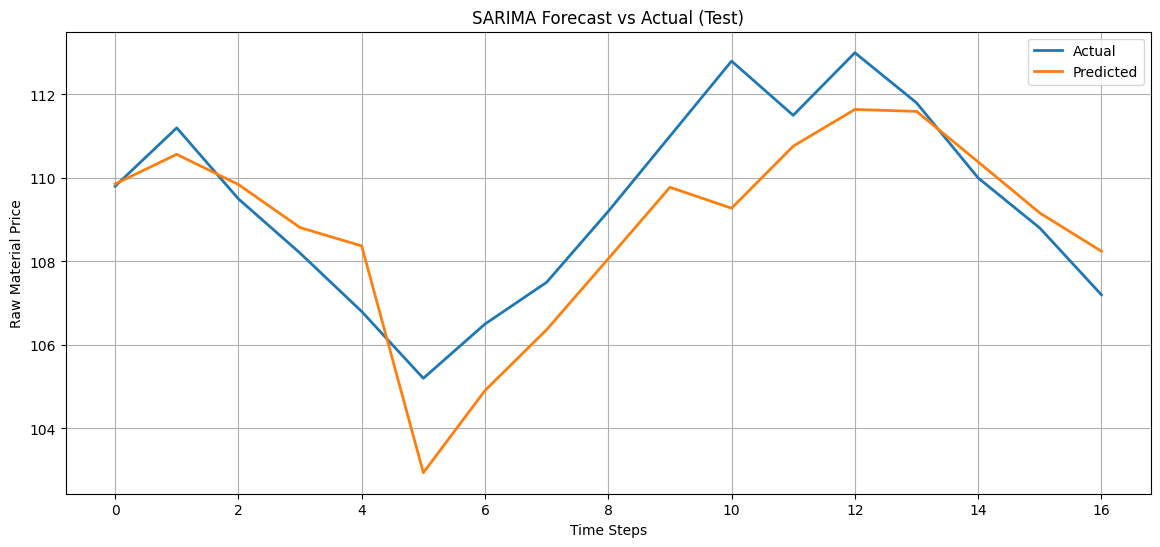

In [202]:
actual = y_test.values
predicted = y_forecast.values

plt.figure(figsize=(14,6))

plt.plot(actual, label="Actual", linewidth=2)
plt.plot(predicted, label="Predicted", linewidth=2)

plt.title("SARIMA Forecast vs Actual (Test)")
plt.xlabel("Time Steps")
plt.ylabel("Raw Material Price")
plt.legend()
plt.grid(True)

plt.show()

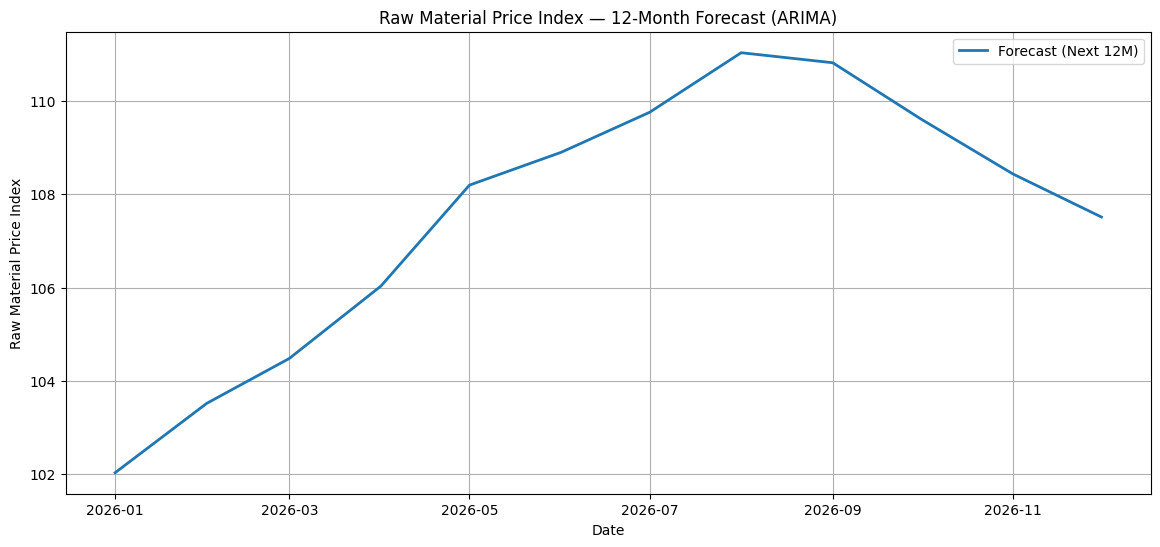

In [203]:
y = df_PE["raw_material_price_index"].astype(float)

model = SARIMAX( y ,order=best_order, seasonal_order=best_seasonal, trend=None, enforce_stationarity=False, enforce_invertibility=False)
fit = model.fit()

future_price = fit.forecast(steps=12)

# convert ONLY the last index value (no dataset change)
last_date = pd.to_datetime(df_LSF.index[-1])

future_price.index = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=12,
    freq="MS"
)

# ---- Plot forecast only
plt.figure(figsize=(14,6))
plt.plot(future_price.index, future_price.values, label="Forecast (Next 12M)", linewidth=2)
plt.title("Raw Material Price Index — 12-Month Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Raw Material Price Index")
plt.legend()
plt.grid(True)
plt.show()


## Predicting Future Energy

In [204]:
best_order, best_seasonal, sarima_results = sarima_grid_search(df_PE["energy_cost_index"])

print("Best order:", best_order)
print("Best seasonal_order:", best_seasonal)

sarima_results.head()

Best order: (2, 2, 3)
Best seasonal_order: (0, 1, 0, 12)


,mae,rmse,p,d,q,P,D,Q,s
0,0.553518,0.753634,2,2,3,0,1,0,12
1,0.571494,0.768443,3,1,2,0,1,0,12
2,0.591450,0.783384,2,1,2,0,1,0,12
3,0.632638,0.752767,2,0,1,0,1,0,12
4,0.663961,0.815142,2,2,2,0,1,0,12


In [205]:
y = df_PE["energy_cost_index"]
split_idx = int(len(y) * 0.8)
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

model = SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

y_forecast = results.forecast(steps=len(y_test))
y_forecast.index = y_test.index

print("Final MAE:", mean_absolute_error(y_test, y_forecast))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, y_forecast)))


Final MAE: 0.553518077075402
Final RMSE: 0.7536338979509661


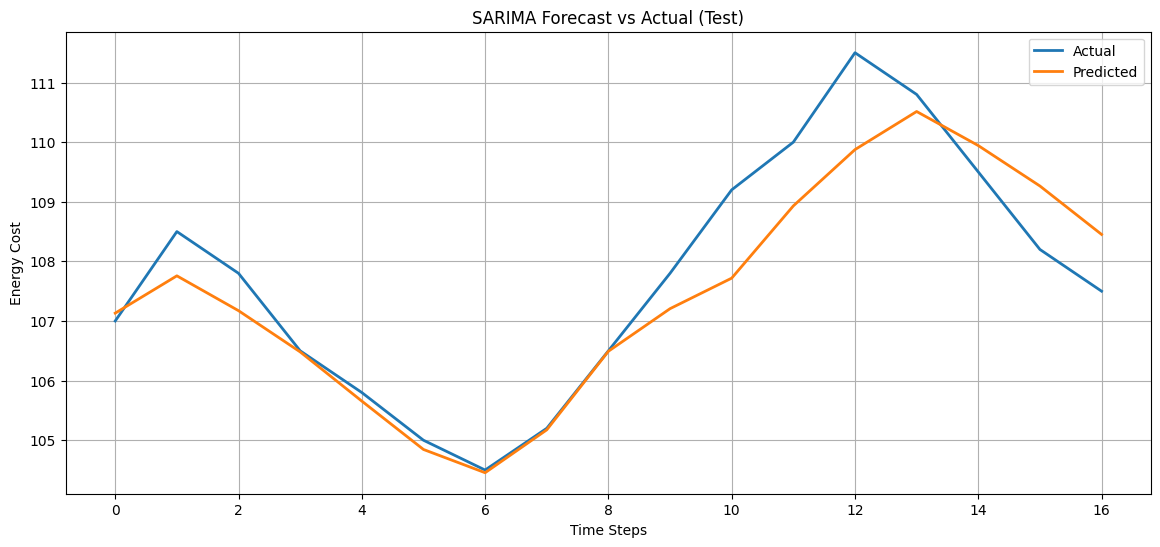

In [206]:
actual = y_test.values
predicted = y_forecast.values

plt.figure(figsize=(14,6))

plt.plot(actual, label="Actual", linewidth=2)
plt.plot(predicted, label="Predicted", linewidth=2)

plt.title("SARIMA Forecast vs Actual (Test)")
plt.xlabel("Time Steps")
plt.ylabel("Energy Cost")
plt.legend()
plt.grid(True)

plt.show()

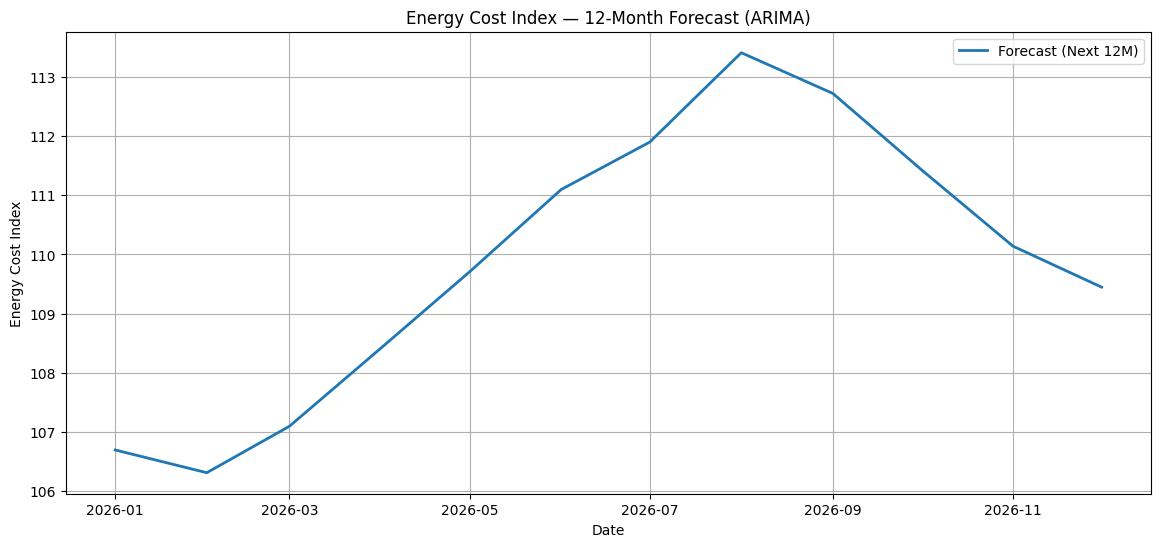

In [207]:
y = df_PE["energy_cost_index"].astype(float)

model = SARIMAX(
    y,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
fit = model.fit()

future_energy = fit.forecast(steps=12)

# convert ONLY the last index value (no dataset change)
last_date = pd.to_datetime(df_PVC.index[-1])

future_energy.index = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=12,
    freq="MS"
)

# ---- Plot forecast only
plt.figure(figsize=(14,6))
plt.plot(future_energy.index, future_energy.values, label="Forecast (Next 12M)", linewidth=2)
plt.title("Energy Cost Index — 12-Month Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Energy Cost Index")
plt.legend()
plt.grid(True)
plt.show()


## Predicting Demand

In [238]:
from sklearn.preprocessing import RobustScaler

binary_cols = [
    "is_peak_construction_season",
    "project_based_demand_flag"
]

scale_cols = [
    "confirmed_contract_volume_tons",
    "number_of_active_projects",
    "raw_material_price_index",
    "energy_cost_index",
    "demand_growth_trend_index",
    "demand_volatility_index"
]

exog_cols = binary_cols + scale_cols

split_idx = int(len(df_XLPE) * 0.8)

train_exog = df_PE.iloc[:split_idx][exog_cols].copy()
test_exog  = df_PE.iloc[split_idx:][exog_cols].copy()

scaler = RobustScaler(quantile_range=(25, 75))
scaler.fit(train_exog[scale_cols])

df_model = df_PE.copy()
df_model[scale_cols] = scaler.transform(df_model[scale_cols])

In [209]:
best_order, best_seasonal, sarimax_results, exog_cols = sarimax_grid_search(df_model)

print("Best SARIMAX order:", best_order)
print("Best SARIMAX seasonal_order:", best_seasonal)

sarimax_results.to_csv("sarimax_grid_results.csv", index=False)
sarimax_results.head(10)


Best SARIMAX order: (1, 0, 2)
Best SARIMAX seasonal_order: (0, 1, 1, 12)


,mae,rmse,p,d,q,P,D,Q,s
0,1.595097,2.494743,1,0,2,0,1,1,12
1,1.604942,2.333754,2,1,3,2,0,2,12
2,1.609242,2.253975,3,0,0,0,1,1,12
3,1.614253,2.226621,0,1,0,0,1,0,12
4,1.617150,2.336950,3,1,1,0,1,1,12
5,1.633378,2.410969,2,1,1,0,1,1,12
6,1.652745,2.292061,1,0,0,0,1,0,12
7,1.660101,2.363144,2,2,0,2,0,2,12
8,1.674924,2.462461,2,0,0,0,1,1,12
9,1.705548,2.260787,3,0,1,0,1,1,12


In [240]:
y_full = df_model[target].astype(float)
X_full = df_model[exog_cols].astype(float)

full_model = SARIMAX(
    y_full,
    exog=X_full,
    order=(1,0,2),
    seasonal_order=(0,1,1,12),
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
full_fit = full_model.fit(disp=False)


In [241]:
H = 12

# --- safe future index WITHOUT changing df_LSF
last_date = pd.to_datetime(df_PE.index[-1])
future_index = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=H,
    freq="MS"
)

# ----------------------------
# 1) Build future_exog (UNSCALED)
# ----------------------------
future_exog = pd.DataFrame(index=future_index)

last_12 = df_PE.tail(12)

is_peak_construction_season = last_12['is_peak_construction_season'].tolist()
confirmed_contract_volume_tons = last_12['confirmed_contract_volume_tons'].tolist()
project_based_demand_flag = last_12['project_based_demand_flag'].tolist()
number_of_active_projects = last_12['number_of_active_projects'].tolist()

# manual inputs (must be length 12)
future_exog["is_peak_construction_season"]     = is_peak_construction_season
future_exog["confirmed_contract_volume_tons"]  = confirmed_contract_volume_tons
future_exog["project_based_demand_flag"]       = project_based_demand_flag
future_exog["number_of_active_projects"]       = number_of_active_projects

# price/energy forecasts (force to 1D & align)
future_price_series  = pd.Series(np.array(future_price).reshape(-1),  index=future_index)
future_energy_series = pd.Series(np.array(future_energy).reshape(-1), index=future_index)

future_exog["raw_material_price_index"] = future_price_series.values
future_exog["energy_cost_index"]        = future_energy_series.values

# placeholders for growth/volatility (seasonal averages from history)
df_tmp = df_PE.copy()
df_tmp.index = pd.to_datetime(df_tmp.index)

growth_by_month = df_tmp.groupby(df_tmp.index.month)["demand_growth_trend_index"].mean()
vol_by_month    = df_tmp.groupby(df_tmp.index.month)["demand_volatility_index"].mean()

future_exog["demand_growth_trend_index"] = [float(growth_by_month[d.month]) for d in future_index]
future_exog["demand_volatility_index"]   = [float(vol_by_month[d.month])    for d in future_index]

# enforce correct order + float
future_exog = future_exog[exog_cols].astype(float)

# ----------------------------
# 2) SCALE future_exog using the SAME fitted scaler (DO NOT FIT AGAIN)
# ----------------------------
future_exog_s = future_exog.copy()
future_exog_s[scale_cols] = scaler.transform(future_exog_s[scale_cols])

# ----------------------------
# 3) Forecast next 12 months using your trained model
# ----------------------------
future_demand_forecast = full_fit.forecast(steps=H, exog=future_exog_s)
future_demand_forecast = pd.Series(future_demand_forecast.values, index=future_index, name="forecast")

# (optional) clip negative demand if you want
future_demand_forecast = future_demand_forecast.clip(lower=0)

future_demand_forecast

2026-01-01     80.678995
2026-02-01     82.623894
2026-03-01     80.686179
2026-04-01     89.678030
2026-05-01     93.097793
2026-06-01    102.199407
2026-07-01    100.509426
2026-08-01    101.254061
2026-09-01    100.422233
2026-10-01     85.555096
2026-11-01     85.034064
2026-12-01     84.834751
Freq: MS, Name: forecast, dtype: float64

In [ ]:
df_PE = df[df["material_name"] == "PE"].copy()

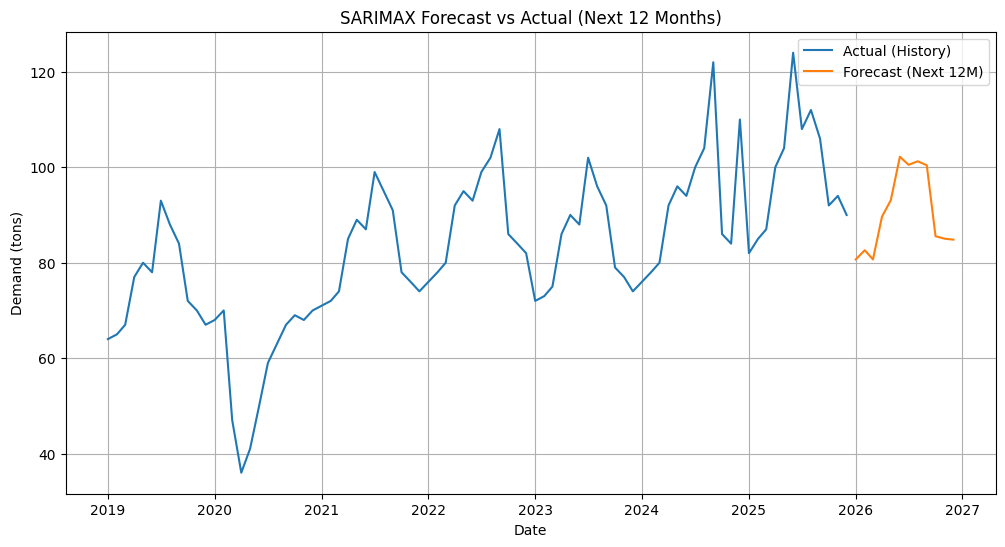

,date,forecast_demand_tons
0,2026-01-01,80.678995
1,2026-02-01,82.623894
2,2026-03-01,80.686179
3,2026-04-01,89.678030
4,2026-05-01,93.097793
5,2026-06-01,102.199407
6,2026-07-01,100.509426
7,2026-08-01,101.254061
8,2026-09-01,100.422233
9,2026-10-01,85.555096


In [243]:
# ---- SAFE PLOT (fixes tz / UnitData error) ----

hist_x = pd.to_datetime(df_PE.index)
fut_x  = pd.to_datetime(future_demand_forecast.index)

plt.figure(figsize=(12, 6))

plt.plot(hist_x, df_PE["actual_consumption_tons"].values, label="Actual (History)")
plt.plot(fut_x, future_demand_forecast.values, label="Forecast (Next 12M)")

plt.title("SARIMAX Forecast vs Actual (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Demand (tons)")
plt.legend()
plt.grid(True)

plt.show()

# ----------------------------
# 5) Export forecast
# ----------------------------
forecast_df = future_demand_forecast.reset_index()
forecast_df.columns = ["date", "forecast_demand_tons"]
forecast_df.to_csv("Forecast_PE.csv",index=False)

forecast_df.head(12)

# XLPE

## EDA

In [104]:
df_XLPE = df[df["material_name"] == "XLPE"]

In [105]:
df_XLPE.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84 entries, 1/1/2019 to 12/1/2025
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   material_name                   84 non-null     object 
 1   actual_consumption_tons         84 non-null     int64  
 2   month                           84 non-null     int64  
 3   quarter                         84 non-null     int64  
 4   is_peak_construction_season     84 non-null     int64  
 5   confirmed_contract_volume_tons  84 non-null     int64  
 6   project_based_demand_flag       84 non-null     int64  
 7   number_of_active_projects       84 non-null     int64  
 8   raw_material_price_index        84 non-null     float64
 9   energy_cost_index               84 non-null     float64
 10  demand_growth_trend_index       84 non-null     float64
 11  demand_volatility_index         84 non-null     float64
dtypes: float64(4), int64(7), obje

In [106]:
df_XLPE = df_XLPE.drop(columns=["material_name", "quarter", "month"])

In [107]:
train_size = int(0.8 * len(df_XLPE))

test_size = len(df_XLPE) - train_size

print(f"Train size: {train_size}")
print(f"Test size: {test_size}")

Train size: 67
Test size: 17


In [108]:
data = df_XLPE.values
train = data[:train_size, :]

test = data[train_size-12:, :]

In [109]:
feature_cols = [c for c in df_XLPE.columns if c != "actual_consumption_tons"]

train_size = int(0.8 * len(df_XLPE))
train_df = df_XLPE.iloc[:train_size]
test_df  = df_XLPE.iloc[train_size:]

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = x_scaler.fit_transform(train_df[feature_cols])
X_test_scaled  = x_scaler.transform(test_df[feature_cols])

y_train_scaled = y_scaler.fit_transform(train_df[["actual_consumption_tons"]]).ravel()
y_test_scaled  = y_scaler.transform(test_df[["actual_consumption_tons"]]).ravel()


<Axes: xlabel='date'>

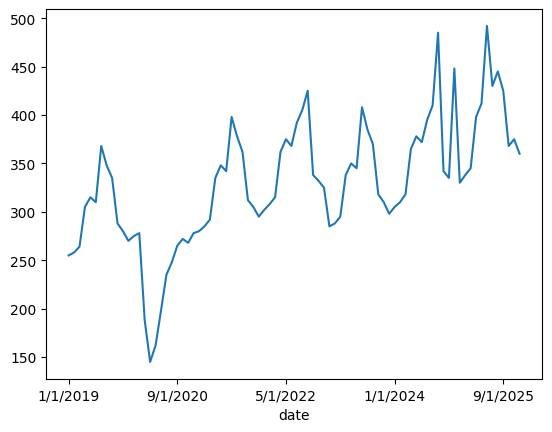

In [110]:
df_XLPE["actual_consumption_tons"].plot()

## SARIMAX Model

In [ ]:
best_order, best_seasonal, sarimax_results, exog_cols = sarimax_grid_search(df_XLPE)

print("Best SARIMAX order:", best_order)
print("Best SARIMAX seasonal_order:", best_seasonal)

sarimax_results.to_csv("sarimax_grid_results.csv", index=False)
sarimax_results.head(10)


In [ ]:
target = "actual_consumption_tons"

y = df_XLPE[target].astype(float)
X = df_XLPE[exog_cols].astype(float)

split_idx = int(len(df_XLPE) * 0.8)
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]

final_model = SARIMAX(
    y_train,
    exog=X_train,
    order=(2,1,2),
    seasonal_order=(0,1,0,12),
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_fit = final_model.fit(disp=False)

y_forecast = final_fit.forecast(steps=len(y_test), exog=X_test)

print("Final MAE:", mean_absolute_error(y_test, y_forecast))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, y_forecast)))


In [ ]:
actual = y_test.values
predicted = y_forecast.values

plt.figure(figsize=(14,6))

plt.plot(actual, label="Actual", linewidth=2)
plt.plot(predicted, label="Predicted", linewidth=2)

plt.title("SARIMAX Forecast vs Actual (Test)")
plt.xlabel("Time Steps")
plt.ylabel("Consumption (tons)")
plt.legend()
plt.grid(True)

plt.show()

## Predicting Future Price

In [214]:
best_order, best_seasonal, sarima_results = sarima_grid_search(df_XLPE["raw_material_price_index"])

print("Best order:", best_order)
print("Best seasonal_order:", best_seasonal)

sarima_results.head()

Best order: (2, 0, 1)
Best seasonal_order: (0, 1, 0, 12)


,mae,rmse,p,d,q,P,D,Q,s
0,0.688444,0.952846,2,0,1,0,1,0,12
1,1.211638,1.481619,3,2,1,2,1,2,12
2,1.251348,1.633167,2,0,1,0,1,1,12
3,1.256450,1.600453,1,0,1,1,1,2,12
4,1.257066,1.588241,2,0,3,1,1,2,12


In [215]:
y = df_XLPE["raw_material_price_index"]
split_idx = int(len(y) * 0.8)
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

model = SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

y_forecast = results.forecast(steps=len(y_test))
y_forecast.index = y_test.index

print("Final MAE:", mean_absolute_error(y_test, y_forecast))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, y_forecast)))


Final MAE: 0.688443635678307
Final RMSE: 0.9528458908593803


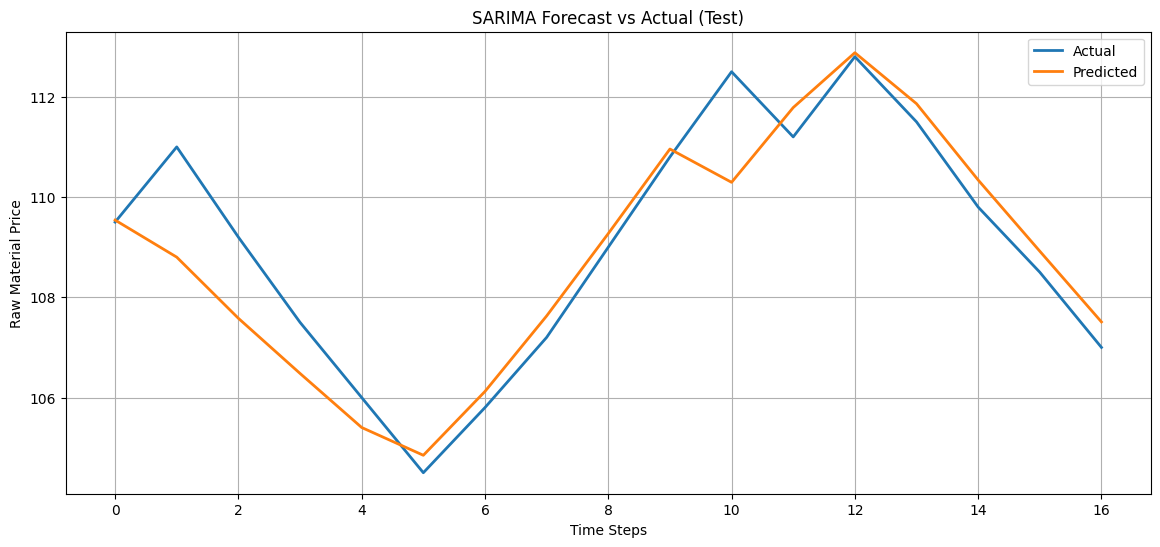

In [216]:
actual = y_test.values
predicted = y_forecast.values

plt.figure(figsize=(14,6))

plt.plot(actual, label="Actual", linewidth=2)
plt.plot(predicted, label="Predicted", linewidth=2)

plt.title("SARIMA Forecast vs Actual (Test)")
plt.xlabel("Time Steps")
plt.ylabel("Raw Material Price")
plt.legend()
plt.grid(True)

plt.show()

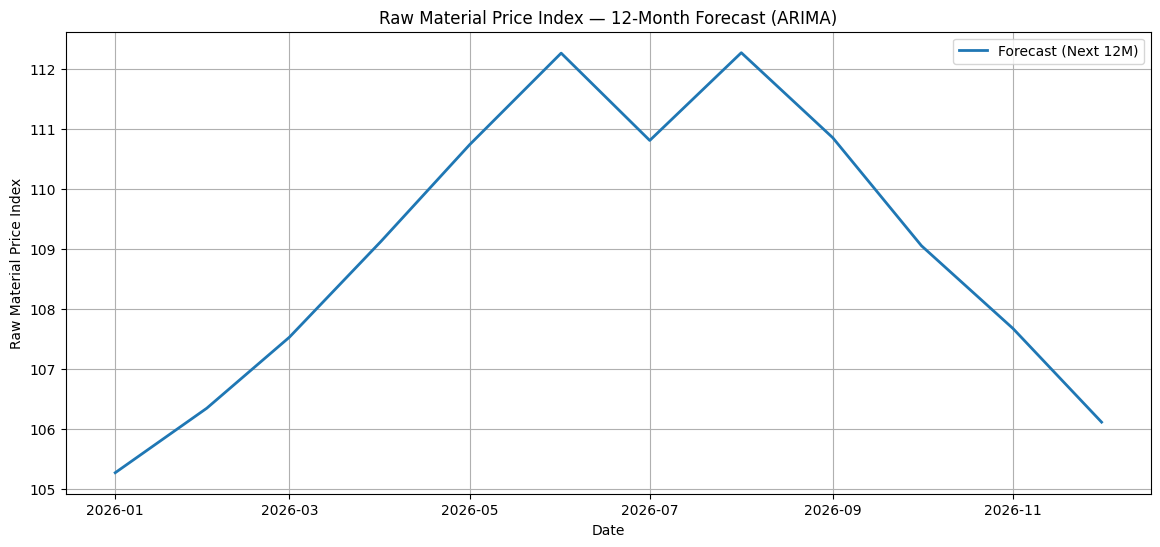

In [217]:
y = df_XLPE["raw_material_price_index"].astype(float)

model = SARIMAX( y ,order=best_order, seasonal_order=best_seasonal, trend=None, enforce_stationarity=False, enforce_invertibility=False)
fit = model.fit()

future_price = fit.forecast(steps=12)

# convert ONLY the last index value (no dataset change)
last_date = pd.to_datetime(df_XLPE.index[-1])

future_price.index = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=12,
    freq="MS"
)

# ---- Plot forecast only
plt.figure(figsize=(14,6))
plt.plot(future_price.index, future_price.values, label="Forecast (Next 12M)", linewidth=2)
plt.title("Raw Material Price Index — 12-Month Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Raw Material Price Index")
plt.legend()
plt.grid(True)
plt.show()


## Predicting Future Energy

In [218]:
best_order, best_seasonal, sarima_results = sarima_grid_search(df_XLPE["energy_cost_index"])

print("Best order:", best_order)
print("Best seasonal_order:", best_seasonal)

sarima_results.head()

Best order: (2, 2, 3)
Best seasonal_order: (0, 1, 0, 12)


,mae,rmse,p,d,q,P,D,Q,s
0,0.553518,0.753634,2,2,3,0,1,0,12
1,0.571494,0.768443,3,1,2,0,1,0,12
2,0.591450,0.783384,2,1,2,0,1,0,12
3,0.632638,0.752767,2,0,1,0,1,0,12
4,0.663961,0.815142,2,2,2,0,1,0,12


In [219]:
y = df_XLPE["energy_cost_index"]
split_idx = int(len(y) * 0.8)
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

model = SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

y_forecast = results.forecast(steps=len(y_test))
y_forecast.index = y_test.index

print("Final MAE:", mean_absolute_error(y_test, y_forecast))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, y_forecast)))


Final MAE: 0.553518077075402
Final RMSE: 0.7536338979509661


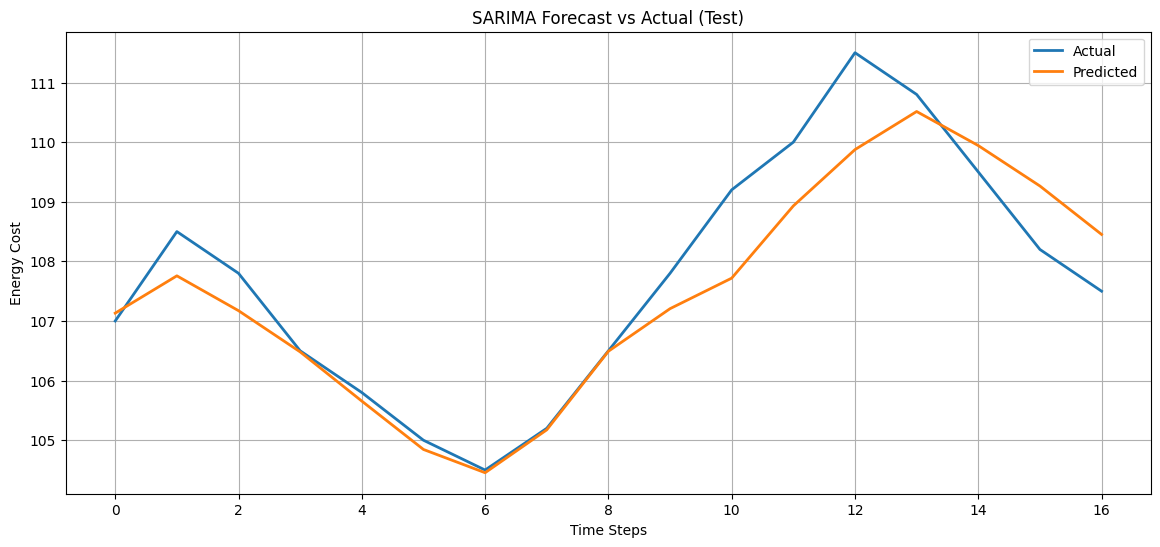

In [220]:
actual = y_test.values
predicted = y_forecast.values

plt.figure(figsize=(14,6))

plt.plot(actual, label="Actual", linewidth=2)
plt.plot(predicted, label="Predicted", linewidth=2)

plt.title("SARIMA Forecast vs Actual (Test)")
plt.xlabel("Time Steps")
plt.ylabel("Energy Cost")
plt.legend()
plt.grid(True)

plt.show()

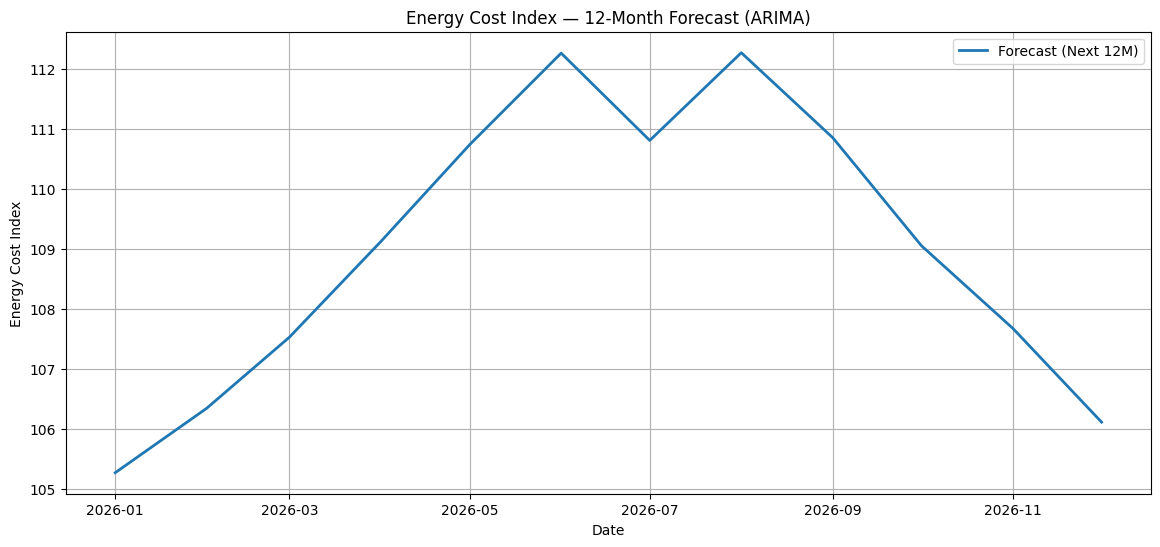

In [221]:
y = df_XLPE["energy_cost_index"].astype(float)

model = SARIMAX(
    y,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
fit = model.fit()

future_energy = fit.forecast(steps=12)

# convert ONLY the last index value (no dataset change)
last_date = pd.to_datetime(df_XLPE.index[-1])

future_energy.index = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=12,
    freq="MS"
)

# ---- Plot forecast only
plt.figure(figsize=(14,6))
plt.plot(future_price.index, future_price.values, label="Forecast (Next 12M)", linewidth=2)
plt.title("Energy Cost Index — 12-Month Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Energy Cost Index")
plt.legend()
plt.grid(True)
plt.show()


## Predicting Demand

In [222]:
from sklearn.preprocessing import RobustScaler

binary_cols = [
    "is_peak_construction_season",
    "project_based_demand_flag"
]

scale_cols = [
    "confirmed_contract_volume_tons",
    "number_of_active_projects",
    "raw_material_price_index",
    "energy_cost_index",
    "demand_growth_trend_index",
    "demand_volatility_index"
]

exog_cols = binary_cols + scale_cols

split_idx = int(len(df_XLPE) * 0.8)

train_exog = df_XLPE.iloc[:split_idx][exog_cols].copy()
test_exog  = df_XLPE.iloc[split_idx:][exog_cols].copy()

scaler = RobustScaler(quantile_range=(25, 75))
scaler.fit(train_exog[scale_cols])

df_model = df_XLPE.copy()
df_model[scale_cols] = scaler.transform(df_model[scale_cols])

In [167]:
best_order, best_seasonal, sarimax_results, exog_cols = sarimax_grid_search(df_model)

print("Best SARIMAX order:", best_order)
print("Best SARIMAX seasonal_order:", best_seasonal)

sarimax_results.to_csv("sarimax_grid_results.csv", index=False)
sarimax_results.head(10)


Best SARIMAX order: (1, 1, 0)
Best SARIMAX seasonal_order: (1, 0, 0, 12)


,mae,rmse,p,d,q,P,D,Q,s
0,2.702548,4.069462,1,1,0,1,0,0,12
1,2.769804,3.993462,0,1,3,1,0,0,12
2,2.822199,4.217121,1,1,1,1,0,0,12
3,2.925999,3.816424,0,1,0,1,0,0,12
4,3.191727,4.885015,3,2,2,0,1,1,12
5,3.202478,4.020423,2,1,0,1,0,0,12
6,3.273907,4.160838,3,0,0,0,1,1,12
7,3.383161,4.413019,3,1,3,0,1,0,12
8,3.392760,3.824948,0,1,3,0,0,0,12
9,3.393306,4.823606,2,2,2,0,1,1,12


In [168]:
y_full = df_model[target].astype(float)
X_full = df_model[exog_cols].astype(float)

full_model = SARIMAX(
    y_full,
    exog=X_full,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)
full_fit = full_model.fit(disp=False)


In [169]:
H = 12

# --- safe future index WITHOUT changing df_LSF
last_date = pd.to_datetime(df_XLPE.index[-1])
future_index = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=H,
    freq="MS"
)


future_exog = pd.DataFrame(index=future_index)

last_12 = df_XLPE.tail(12)

is_peak_construction_season = last_12['is_peak_construction_season'].tolist()
confirmed_contract_volume_tons = last_12['confirmed_contract_volume_tons'].tolist()
project_based_demand_flag = last_12['project_based_demand_flag'].tolist()
number_of_active_projects = last_12['number_of_active_projects'].tolist()


# manual inputs (must be length 12)
future_exog["is_peak_construction_season"]     = is_peak_construction_season
future_exog["confirmed_contract_volume_tons"]  = confirmed_contract_volume_tons
future_exog["project_based_demand_flag"]       = project_based_demand_flag
future_exog["number_of_active_projects"]       = number_of_active_projects

# price/energy forecasts (force to 1D & align)
future_price_series  = pd.Series(np.array(future_price).reshape(-1),  index=future_index)
future_energy_series = pd.Series(np.array(future_energy).reshape(-1), index=future_index)

future_exog["raw_material_price_index"] = future_price_series.values
future_exog["energy_cost_index"]        = future_energy_series.values

# placeholders for growth/volatility (seasonal averages from history)
df_tmp = df_XLPE.copy()
df_tmp.index = pd.to_datetime(df_tmp.index)

growth_by_month = df_tmp.groupby(df_tmp.index.month)["demand_growth_trend_index"].mean()
vol_by_month    = df_tmp.groupby(df_tmp.index.month)["demand_volatility_index"].mean()

future_exog["demand_growth_trend_index"] = [float(growth_by_month[d.month]) for d in future_index]
future_exog["demand_volatility_index"]   = [float(vol_by_month[d.month])    for d in future_index]

# enforce correct order + float
future_exog = future_exog[exog_cols].astype(float)

# ----------------------------
# 2) SCALE future_exog using the SAME fitted scaler (DO NOT FIT AGAIN)
# ----------------------------
future_exog_s = future_exog.copy()
future_exog_s[scale_cols] = scaler.transform(future_exog_s[scale_cols])

# ----------------------------
# 3) Forecast next 12 months using your trained model
# ----------------------------
future_demand_forecast = full_fit.forecast(steps=H, exog=future_exog_s)
future_demand_forecast = pd.Series(future_demand_forecast.values, index=future_index, name="forecast")

# (optional) clip negative demand if you want
future_demand_forecast = future_demand_forecast.clip(lower=0)

future_demand_forecast

2026-01-01    324.359707
2026-02-01    330.690358
2026-03-01    324.739996
2026-04-01    356.017353
2026-05-01    371.056768
2026-06-01    397.885759
2026-07-01    403.736110
2026-08-01    407.112845
2026-09-01    413.214012
2026-10-01    349.737404
2026-11-01    347.738072
2026-12-01    353.170735
Freq: MS, Name: forecast, dtype: float64

In [170]:
df_XLPE = df[df["material_name"] == "XLPE"].copy()

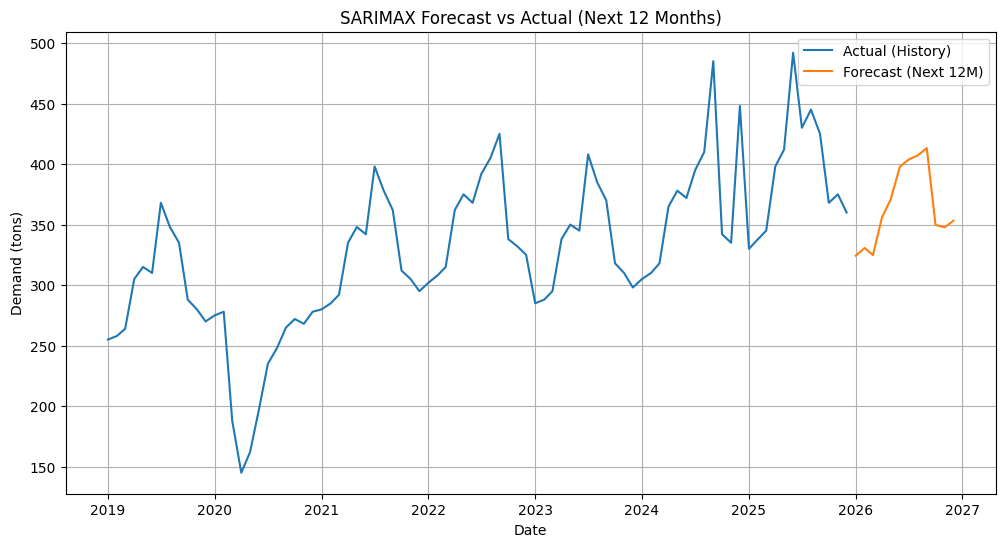

,date,forecast_demand_tons
0,2026-01-01,324.359707
1,2026-02-01,330.690358
2,2026-03-01,324.739996
3,2026-04-01,356.017353
4,2026-05-01,371.056768
5,2026-06-01,397.885759
6,2026-07-01,403.736110
7,2026-08-01,407.112845
8,2026-09-01,413.214012
9,2026-10-01,349.737404


In [171]:
hist_x = pd.to_datetime(df_XLPE.index)
fut_x  = pd.to_datetime(future_demand_forecast.index)

plt.figure(figsize=(12, 6))

plt.plot(hist_x, df_XLPE["actual_consumption_tons"].values, label="Actual (History)")
plt.plot(fut_x, future_demand_forecast.values, label="Forecast (Next 12M)")

plt.title("SARIMAX Forecast vs Actual (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Demand (tons)")
plt.legend()
plt.grid(True)

plt.show()

forecast_df = future_demand_forecast.reset_index()
forecast_df.columns = ["date", "forecast_demand_tons"]
forecast_df.to_csv("Forecast_XLPE.csv",index=False)

forecast_df.head(12)

# Forecasted Demand Output

In [244]:
import pandas as pd

# =========================
# File paths (edit if needed)
# =========================
FILES = {
    "LSF":  "Forecast_LSF.csv",
    "XLPE": "Forecast_XLPE.csv",
    "PE":   "Forecast_PE.csv",
    "PVC":  "Forecast_PVC.csv",
}

OUTPUT_CSV = "Monthly_Polymer_Demand.csv"

MONTH_ORDER = ["JAN","FEB","MAR","APR","MAY","JUN",
               "JUL","AUG","SEP","OCT","NOV","DEC"]

# =========================
# Helper functions
# =========================
def detect_date_col(df):
    for c in ["Date", "date", "period", "Period", "Month", "month"]:
        if c in df.columns:
            return c
    return df.columns[0]

def detect_value_col(df, date_col):
    numeric_cols = df.drop(columns=[date_col]).select_dtypes(include="number").columns
    return numeric_cols[0]

# =========================
# Load & process each dataset
# =========================
monthly_data = {}

for material, path in FILES.items():
    df = pd.read_csv(path)

    date_col  = detect_date_col(df)
    value_col = detect_value_col(df, date_col)

    df["Date"] = pd.to_datetime(df[date_col], errors="coerce")
    df["Month"] = df["Date"].dt.strftime("%b").str.upper()

    monthly_sum = (
        df.groupby("Month")[value_col]
        .sum()
        .reindex(MONTH_ORDER)
    )

    monthly_data[material] = monthly_sum

# =========================
# Combine into final table
# =========================
final_df = pd.DataFrame(monthly_data)
final_df["LSF"] = final_df["LSF"].astype(int)
final_df["XLPE"] = final_df["XLPE"].astype(int)
final_df["PE"] = final_df["PE"].astype(int)
final_df["PVC"] = final_df["PVC"].astype(int)
final_df.index.name = "Period"

# Enforce column order
final_df = final_df[["LSF", "XLPE", "PE", "PVC"]]

# =========================
# Export as CSV
# =========================
final_df.reset_index().to_csv(OUTPUT_CSV, index=False)

print("CSV exported:", OUTPUT_CSV)


CSV exported: Monthly_Polymer_Demand.csv
